### GROUP MEMBER:
**1. Van Le:** vanle@buffalo.edu - CSE 487

**2. Maria Anthony:** mariniv@buffalo.edu - CSE 587

**3. Anushka:** atiwari4@buffalo.edu - CSE 587

# STOCK-BASED RECOMMENDATION SYSTEM 

# PHASE I - EDA

## 1. Install and import necessary libraries:

In [ ]:
!pip install pmdarima
!pip install xgboost
! pip install graph-based-clustering 
!pip install git+https://github.com/huggingface/transformers
!pip install transformers
!pip install tensorflow_probability==0.12.2
!pip install contractions
!pip install emoji
!pip install emoticon_fix
!pip install -U accelerate
!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm
!python -m spacy info

In [1]:
import os, sys
import requests
import glob
import datetime
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import string
import re
import ta
import itertools
import spacy
import emoji
import collections
from pyspark.sql import SparkSession
from datetime import datetime, date
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, confusion_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas.plotting import lag_plot
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
# nltk.download('omw-1.4')
from emoticon_fix import emoticon_fix
from scipy.sparse import coo_matrix
# Use a pipeline as a high-level helper
# from transformers import pipeline
# pipe_sentiment = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

## 2. Data Acquisition and Preparation:

### 2.1. NASDAQ Data Retrieval

In [ ]:
# Read cvs file to Dataframe 
ticker_df = pd.read_csv("//Users//marianivethaantonypushparaj//Downloads//nasdaq_ticker_symbols.csv").reset_index(drop=True)
ticker_df.head()

### 2.2. Historical Stocks Data

In [ ]:
# Define the directory where your CSV files are located
folder_path = 'Dataset//Stocks'

# Initialize an empty DataFrame to store the concatenated data
stock_df = []

# Loop through all files in the directory
for filename in os.listdir(folder_path):
    if filename.endswith(".us.txt"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, header=None, names=["Date", "Open", "High", "Low", "Close", "Volume", "OpenInt"])
        
        # Extract the stock symbol from the file name
        stock_ticker = filename.split(".")[0].upper()
        
        # Add a "stock" column with the stock symbol
        df['Ticker'] = stock_ticker
        
        # Drop the first row 
        df = df.iloc[1:]
        
        # Append the DataFrame to the concatenated_data DataFrame
        stock_df.append(df)
        print("Finished processing", filename)

# Save the concatenated data to a new CSV file
stock_df = pd.concat(stock_df, ignore_index=True)

In [ ]:
# Sort the DataFrame based on the 'Ticker' column
stock_df.sort_values(by='Ticker', inplace=True)

# Save the sorted data to a new CSV file
# stock_df.to_csv('//Users//vanle//Downloads//stock_sorted.csv', index=False)

merged_df = pd.read_csv("//Users//marianivethaantonypushparaj//Downloads//stock_sorted.csv").reset_index(drop=True)

# Merge 2 dataframes using an inner join on the 'Ticker' column
merged_df = pd.merge(merged_df, ticker_df, left_on='Ticker', right_on='Symbol', how='inner')

# Drop the duplicate 'Ticker' column 
merged_df.drop(columns=['Symbol'], inplace=True)

# Drop the 'Volume_x' column
merged_df.drop(columns=['Volume_y'], inplace=True)

# Rename the 'Volume_y' column to 'Volume'
merged_df.rename(columns={'Volume_x': 'Volume'}, inplace=True)
merged_df

### 2.3. Exploratory Data Analysis

#### 2.3.1. Data Cleaning

In [ ]:
# Check the Uniqueness of 'OpenInt' Column
merged_df['OpenInt'].nunique()

# Drop 'OpenInt' and 'IPO Year' column since it has no contribution in our data
merged_df = merged_df.drop(['OpenInt'], axis=1)

# Remove duplicate rows
merged_df=merged_df.drop_duplicates(subset=['Open', 'High', 'Low', 'Close','Volume'], keep='last')

# Convert 'Date' column to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Check for missing values
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)

# Fill NaN values in these column: 'Country', 'Sector', 'Industry'  with 'Other'
merged_df[['Country', 'Sector', 'Industry']] = merged_df[['Country', 'Sector', 'Industry']].fillna('Other')

In [ ]:
# Check Data Types of Each Column
merged_df.dtypes

In [ ]:
# Convert 'Open', 'High', 'Low', 'Close', 'Last Sale' columns to float
merged_df['Open'] = merged_df['Open'].astype(str).str.replace('$', '').astype(float)
merged_df['High'] = merged_df['High'].astype(str).str.replace('$', '').astype(float)
merged_df['Low'] = merged_df['Low'].astype(str).str.replace('$', '').astype(float)
merged_df['Close'] = merged_df['Close'].astype(str).str.replace('$', '').astype(float)
merged_df['Last Sale'] = merged_df['Last Sale'].astype(str).str.replace('$', '').astype(float)

# Convert 'Volume' column to integer (remove commas)
merged_df['Volume'] = merged_df['Volume'].astype(str).str.replace(',', '').astype(int)

# Convert '% Change' column to float, remove '%' and handle missing values
merged_df['% Change'] = merged_df['% Change'].astype(str).str.replace('%', '')
merged_df['% Change'] = pd.to_numeric(merged_df['% Change'], errors='coerce')

# Arranging the companies based on Date
merged_df = merged_df.sort_values(['Ticker','Date']).reset_index()

In [ ]:
# Calculate Percentage Change in 'Volume'
merged_df['Volume change'] = merged_df['Volume'].pct_change() * 100

# Finding largest values of volume column
comp_volume = merged_df.groupby('Name')['Volume'].sum()
comp_volume.nlargest(10)
comp_volume = pd.DataFrame(comp_volume)
comp_volume = comp_volume.reset_index()

# Dropping the data of those companies because if it shows infinity or o
for i in range(0,len(comp_volume)):
    if comp_volume['Volume'][i]=='inf' or comp_volume['Volume'][i]<=0:
        merged_df=merged_df.drop(merged_df[merged_df['Name'] == comp_volume['Name'][i]].index)

In [ ]:
#Checking if any outliers in Open,High,Low and Close as price cant be negative or 0
merged_df = merged_df.drop(merged_df[merged_df['Open'] <=0].index)
merged_df = merged_df.drop(merged_df[merged_df['High'] <=0].index)
merged_df = merged_df.drop(merged_df[merged_df['Low'] <=0].index)
merged_df = merged_df.drop(merged_df[merged_df['Close'] <=0].index)
merged_df = merged_df.drop(merged_df[merged_df['Last Sale'] <=0].index)

#### 2.3.2. EDA

##### Sector and Industry Breakdown of Company Data

In [ ]:
# Sector and Industry Analysis
sector_counts = ticker_df['Sector'].value_counts()
industry_counts = ticker_df['Industry'].value_counts()

# Plot the histogram of company sectors and industries 
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sector_counts.plot(kind='bar')
plt.title('Fig 1. Number of Companies by Sector', fontsize=15)
plt.ylabel('Sector counts')
plt.xlabel('Industries')

plt.subplot(1, 2, 2)
industry_counts.head(10).plot(kind='bar')
plt.title('Fig 2. Top 10 Industries by Company Count', fontsize=15)
plt.xlabel('Industries')
plt.ylabel('No. of industries based on count')
plt.show()

##### Relative contribution of each country in stock markets

In [ ]:
# Country Analysis
# Count the occurrences of each country in 'Country'
country_counts = ticker_df['Country'].value_counts().head(10)

# Plot a pie chart of the top 10 countries
plt.figure(figsize=(12, 10))
country_counts.plot(kind='pie', autopct='%1.2f%%')
plt.title('Fig 3. Distribution of Top 10 Countries with many companies', fontsize=15)
plt.ylabel('Country', fontsize=14)
plt.legend()
plt.show()

In [ ]:
# Plot a pie chart of the countries excluding the top 10
plt.figure(figsize=(12,10))
drop_catgs = ['United States','Canada','China','Israel','United Kingdom','Bermuda','Singapore','Hong Kong','Cayman Islands','Greece']
country_counts1=(merged_df['Country'].value_counts()).drop(drop_catgs)
country_counts1.plot(kind='pie')
plt.title('Fig 4. Distribution of Companies by Country without Top 10 countries', fontsize=15)
plt.ylabel('Country', fontsize=14)
plt.show()

##### Identify relationships between these variables using correlation matrix

In [ ]:
# Correlation Matrix
plt.figure(figsize=(16, 10))
plt.title('Fig 5. Correlation matrix of historical and current market information', fontsize=15)
correlation_matrix = merged_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

##### Exploring Market Cap Variation and Distribution

In [ ]:
# Market Cap by Sectors
plt.figure(figsize=(20, 6))
palette = sns.color_palette('tab10')
sns.boxplot(x='Sector', y='Market Cap', data=merged_df, palette=palette)
plt.title('Fig 6. Market Cap by Sector', fontsize=15)
plt.xlabel('Sector', fontsize=14)
plt.ylabel('Market Cap', fontsize=14)
plt.show()

##### Analyze market cap quartiles

In [ ]:
# Define the number of quartiles
num_quantiles = 4 

# Calculate the quartile values for market cap
quartiles = merged_df['Market Cap'].quantile([0, 0.25, 0.5, 0.75, 1])

# Create masks for each quartile
mask_1st_quartile = (merged_df['Market Cap'] >= quartiles[0]) & (merged_df['Market Cap'] <= quartiles[0.25])
mask_2nd_quartile = (merged_df['Market Cap'] > quartiles[0.25]) & (merged_df['Market Cap'] <= quartiles[0.5])
mask_3rd_quartile = (merged_df['Market Cap'] > quartiles[0.5]) & (merged_df['Market Cap'] <= quartiles[0.75])
mask_4th_quartile = (merged_df['Market Cap'] > quartiles[0.75])

# Create DataFrames for each quartile
quartile_1 = merged_df[mask_1st_quartile]
quartile_2 = merged_df[mask_2nd_quartile]
quartile_3 = merged_df[mask_3rd_quartile]
quartile_4 = merged_df[mask_4th_quartile]

# Descriptive statistic for market cap quartiles
quartile_1.describe()
quartile_2.describe()
quartile_3.describe()
quartile_4.describe()

##### Understanding Trading Volume Dynamics by Sector

In [ ]:
# Trading Volume Analysis
plt.figure(figsize=(20, 6))
palette = sns.color_palette("husl", 8)
sns.boxplot(x='Sector', y='Volume', data=merged_df)
plt.title('Fig 7. Trading Volume by Sector', fontsize=15)
plt.show()

##### Calculate trading volume statistics by sector

In [ ]:
# Calculate trading volume statistics by sector
volume_stats = merged_df.groupby('Sector')['Volume'].describe()
print(volume_stats)

In [ ]:
# Create a box plot to visualize trading volume distribution by sector
plt.figure(figsize=(12, 8))
sns.boxplot(x='Sector', y='Volume', data=merged_df, order=volume_stats.index, palette='Set3')
plt.title('Fig 8. Trading Volume Distribution by Sector', fontsize=15)
plt.xlabel('Sector', fontsize=14)
plt.ylabel('Trading Volume', fontsize=14)
plt.xticks(rotation=45)
plt.show()

##### Correlation matrix to analyze relationships between trading volume and other variables

In [ ]:
# Correlation matrix to analyze relationships between trading volume and other variables
correlation_matrix = merged_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix[['Volume']], annot=True, cmap='coolwarm')
plt.title('Fig 9. Correlation of Trading Volume with Other Variables', fontsize=15)
plt.show()

##### Time-series plot for sample stock

In [ ]:
# Filter the data for AAPL stock
aapl_df = merged_df[merged_df['Ticker'] == 'AAPL']
# 'Date' as the index 
aapl_df.set_index('Date', inplace=True)
# Plotting the closing prices
plt.figure(figsize=(12, 6))
sns.set_style('ticks')
sns.lineplot(data=aapl_df, x='Date', y='Close', color='firebrick')
sns.despine()
plt.title('Fig 10. The AAPL Stock Close Price Over Time', size='x-large')
plt.show()

##### Finding top 5 companies performance stocks based on last sale value

In [ ]:
# Find the names of the top 5 companies based on 'Last Sale' values 
top5 = merged_df['Last Sale'].unique()
top5_price = sorted(top5, reverse=True)[:5]
top5_price

In [ ]:
# Append top 5 companies to the top_companies list
top_companies = []
top_companies.append(merged_df[merged_df['Last Sale'] == 5888.47]['Name'])
top_companies.append(merged_df[merged_df['Last Sale'] == 3780.66]['Name'])
top_companies.append(merged_df[merged_df['Last Sale'] == 2530.76]['Name'])
top_companies.append(merged_df[merged_df['Last Sale'] == 1870.47]['Name'])
top_companies.append(merged_df[merged_df['Last Sale'] == 1866.01]['Name'])
top_companies

In [ ]:
# Plot top 5 companies stock prices
Top1_df = merged_df[merged_df['Name'] == 'NVR Inc. Common Stock']
Top2_df = merged_df[merged_df['Name'] == 'Seaboard Corporation Common Stock']
Top3_df = merged_df[merged_df['Name'] == 'AutoZone Inc. Common Stock']
Top4_df = merged_df[merged_df['Name'] == 'Texas Pacific Land Corporation Common Stock']
Top5_df = merged_df[merged_df['Name'] == 'Chipotle Mexican Grill Inc. Common Stock']

plt.figure(figsize=(14,6))
sns.set_style("ticks")
sns.lineplot(data=Top1_df,x="Date",y='Close',color='firebrick',label='NVR Inc. Common Stock')
sns.lineplot(data=Top2_df,x="Date",y='Close',color='k',label='Seaboard Corporation Common Stock')
sns.lineplot(data=Top3_df,x="Date",y='Close',color='y',label='AutoZone Inc. Common Stock')
sns.lineplot(data=Top4_df,x="Date",y='Close',color='purple',label='Texas Pacific Land Corporation Common Stock')
sns.lineplot(data=Top5_df,x="Date",y='Close',color='g',label='Chipotle Mexican Grill Inc. Common Stock')
sns.despine()
plt.title("Fig 11. The Stock Price Graph for Top 5 biggest Last sale companies all over the world",size='x-large',color='blue')

##### Finding the worst 5 companies performance stock based on last sale value

In [ ]:
# Find worst performance companies based on sales
worst5= merged_df['Last Sale'].unique()
worst_price = sorted(worst5)[:5]
worst_price

In [ ]:
low_perf = []
low_perf.append(merged_df[merged_df['Last Sale'] == 0.01]['Name'])
low_perf.append(merged_df[merged_df['Last Sale'] == 0.0401]['Name'])
low_perf.append(merged_df[merged_df['Last Sale'] == 0.05]['Name'])
low_perf.append(merged_df[merged_df['Last Sale'] == 0.0588]['Name'])
low_perf.append(merged_df[merged_df['Last Sale'] == 0.09]['Name'])
low_perf

In [ ]:
# Plot the worst companies 
Low1_df = merged_df[merged_df['Name'] == 'Global Partner Acquisition Corp II Warrant']
Low2_df = merged_df[merged_df['Name'] == 'Crixus BH3 Acquisition Company Warrants']
Low3_df = merged_df[merged_df['Name'] == 'Rose Hill Acquisition Corporation Warrant']
Low4_df = merged_df[merged_df['Name'] == 'Oxbridge Re Holdings Limited Warrant expiring']
Low5_df = merged_df[merged_df['Name'] == 'Polished Inc. Common Stock']

plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=Low1_df,x="Date",y='Close',color='firebrick',label='Global Partner Acquisition Corp II Warrant')
sns.lineplot(data=Low2_df,x="Date",y='Close',color='k',label='Crixus BH3 Acquisition Company Warrants')
sns.lineplot(data=Low3_df,x="Date",y='Close',color='y',label='Rose Hill Acquisition Corporation Warrant')
sns.lineplot(data=Low4_df,x="Date",y='Close',color='purple',label='Oxbridge Re Holdings Limited Warrant expiring')
sns.lineplot(data=Low5_df,x="Date",y='Close',color='g',label='Polished Inc. Common Stock')
sns.despine()
plt.title("Fig 12. The Stock Price Graph for Least 5 Last sale value companies all over the world",size='x-large',color='blue')

We can find that the dates for the first 4 and the last are unmatched

In [ ]:
Least1_df = merged_df[merged_df['Name'] == 'Global Partner Acquisition Corp II Warrant']
Least2_df = merged_df[merged_df['Name'] == 'Crixus BH3 Acquisition Company Warrants']
Least3_df = merged_df[merged_df['Name'] == 'Rose Hill Acquisition Corporation Warrant']
Least4_df = merged_df[merged_df['Name'] == 'Oxbridge Re Holdings Limited Warrant expiring']

plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=Least2_df,x="Date",y='Close',color='k',label='Crixus BH3 Acquisition Company Warrants')
sns.lineplot(data=Least3_df,x="Date",y='Close',color='y',label='Rose Hill Acquisition Corporation Warrant')
sns.lineplot(data=Least4_df,x="Date",y='Close',color='purple',label='Oxbridge Re Holdings Limited Warrant expiring')
sns.lineplot(data=Least1_df,x="Date",y='Close',color='g',label='Global Partner Acquisition Corp II Warrant')
sns.despine()
plt.title("The Stock Price Graph for Least 4 Last sale value companies all over the world",size='x-large',color='blue')

## 3. Feature Selection and Engineer:

 The most common way used to predict stock price movement is technical analysis. It forecasts the development of stock prices through an analysis of historical market data to identify the movement direction of stock prices and turning points in the time series. Different types of technical in- dicators, such as stochastic oscillator, moving averages, and relative strength index (RSI), are used in prediction models, and the effectiveness of these input features for future stock market forecasting is studied.

### 3.1. Market Indicators

Apart from price features and volume, we choose technical indicators that give an indication of the trend, momentum, or volatility of the stock which also includes candlestick patterns, and strategy features. And, we derived them from raw data to feed them to the models.

**1. Overlap Indicators:** 
- Simple Moving Average (SMA)
- Exponential Moving Average (EMA)
- Kaufman's Adaptive Moving Average (KAMA)

**2. Momentum indicators:** 
- Average Directional Movement Index (ADX)
- Moving Average Convergence/Divergence (MACD)
- Money Flow Index
- Momentum
- Relative Strength Index (RSI)
- Stochastic oscillator
- Rate of Change (ROC)

**3. Volume Indicators:** 
- Chaikin A/D Line (AD)
- Chaikin Oscillator
- On Balance Volume (OBV)

**4. Volatility Indicators:** 
- Average True Range (ATR) 
- Normalized Average True Range
- Bollinger Bands
- Ichimoku Cloud

In [ ]:
# Define the window values for all technical indicators
window=14

# Calculate Simple Moving Average (SMA)
sma = ta.trend.SMAIndicator(merged_df['Close'], window=window, fillna=True)
merged_df['SMA'] = sma.sma_indicator()

# Calculate Kaufman's Adaptive Moving Average (KAMA)
kama = ta.momentum.KAMAIndicator(merged_df['Close'], window=window, pow1=2, pow2=30, fillna=True)
merged_df['KAMA'] = kama.kama()

# Calculate Exponential Moving Average (EMA)
ema = ta.trend.EMAIndicator(merged_df['Close'], window=window, fillna=True)
merged_df['EMA'] = ema.ema_indicator()

# Calculate the Directional Movement Index (ADX)
adx = ta.trend.ADXIndicator(merged_df['High'], merged_df['Low'], merged_df['Close'], window, fillna=True)
merged_df['ADX'] = adx.adx()

# Calculate Moving Average Convergence/Divergence (MACD)
fast_window = 12  
slow_window = 26  
signal_window = 9  
macd = ta.trend.MACD(merged_df['Close'], fast_window, slow_window, signal_window)
merged_df['MACD'] = macd.macd()  
merged_df['MACD Signal Line'] = macd.macd_signal()   

# # Calculate Money Flow Index (MFI)
mfi = ta.momentum.MFIIndicator(merged_df['High'], merged_df['Low'], merged_df['Close'], merged_df['Volume'], window=window, fillna=False)
merged_df['MFI'] = mfi

# Calculate MomentumIndicator
momentum = ta.momentum.MomentumIndicator(merged_df['Close'], window=window, fillna=True)
merged_df['Momentum'] = momentum.momentum()
merged_df['Momentum_Signal'] = momentum.momentum_diff()

# Calculate Relative Strength Index (RSI)
rsi = RSIIndicator(merged_df['Close'], window=window, fillna=True)
merged_df['RSI'] = rsi.rsi()

# Calculate Stochastic Oscillator
stoch = StochasticOscillator(merged_df['High'], merged_df['Low'], merged_df['Close'], window=window)
merged_df['%K'] = stoch.stoch()
merged_df['%D'] = stoch.stoch_signal()

# Calculate Chaikin A/D Line (AD)
chaikin_ad = ta.volume.ChaikinADIndicator(high=merged_df['High'],low=merged_df['Low'], close=merged_df['Close'], volume=merged_df['Volume'])
merged_df['Chaikin_AD'] = chaikin_ad.ad()
merged_df['Chaikin_ADOsc'] = chaikin_ad.ad_osc()

# Calculate On-Balance Volume (OBV)
obv = OnBalanceVolumeIndicator(merged_df['Close'], merged_df['Volume'])
merged_df['OBV'] = obv.on_balance_volume()

# Calculate Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high=merged_df['High'],
                                      low=merged_df['Low'],
                                      close=merged_df['Close'],
                                      window1=9, window2=26, window3=52) 
merged_df['tenkan_sen'] = ichimoku.ichimoku_a()
merged_df['kijun_sen'] = ichimoku.ichimoku_b()
merged_df['senkou_span_a'] = ichimoku.ichimoku_a()
merged_df['senkou_span_b'] = ichimoku.ichimoku_b()

# Calculate Rate of Change (ROC)
roc = ROCIndicator(merged_df['Close'], window=window)
merged_df['ROC'] = roc.roc()

# Calculate Average True Range (ATR)
atr = AverageTrueRange(merged_df['High'], merged_df['Low'], merged_df['Close'], window=window)
merged_df['ATR'] = atr.average_true_range()

# Calculate Normalized Average True Range 
merged_df['Normalized_ATR'] = (merged_df['ATR'] / merged_df['Close']) * 100

# Calculate Bollinger Bands
bollinger_bands = ta.volatility.BollingerBands(merged_df['Close'], window=window, window_dev=2)
merged_df['Bollinger_Bands_Middle'] = bollinger_bands.bollinger_mavg()
merged_df['Bollinger_Bands_Upper'] = bollinger_bands.bollinger_hband()
merged_df['Bollinger_Bands_Lower'] = bollinger_bands.bollinger_lband()

In [ ]:
merged_df = merged_df.dropna()
merged_df

### 3.2. PCA

In [ ]:
# Select the columns for PCA
columns_for_pca = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
data_for_pca = merged_df[columns_for_pca]
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca)
# Create a PCA model with 10 components 
num_components = 10
pca = PCA(n_components=num_components)
pca.fit(scaled_data)
pca_result = pca.transform(scaled_data)

# Create a DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i + 1}' for i in range(num_components)])
# Concatenate the PCA results with `merged_df`
final_df = pd.concat([merged_df, pca_df], axis=1)

In [ ]:
# Explained variance ratio to understand the importance of each component.
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# PHASE II  -  MODEL DEVELOPMENT

#### Read the csv file we have from the Phase I

In [2]:
merged_df = pd.read_csv("stock-feature.csv")
merged_df.head()

,index,Date,Open,High,Low,Close,Volume,Ticker,Name,Last Sale,...,Senkou_SpanA,Senkou_SpanB,Momentum,%K,%D,Chaikin_AD,ROC,ATR,Normalized_ATR,OBV
0,1774,2000-03-10,103.280,104.560,94.505,95.852,2627257,A,Agilent Technologies Inc. Common Stock,109.73,...,46.44025,40.4375,32.566,72.194339,79.998143,8.672989e+06,51.458458,9.762857,10.185345,20272305
1,1717,2000-03-13,87.798,93.793,87.417,88.603,2783398,A,Agilent Technologies Inc. Common Stock,109.73,...,47.35700,40.4375,26.837,56.299320,64.246830,6.925071e+06,43.449471,10.009500,11.297022,17488907
2,1716,2000-03-14,89.782,91.807,80.243,81.935,3733120,A,Agilent Technologies Inc. Common Stock,109.73,...,47.35700,40.5025,15.106,36.268816,46.284068,4.284382e+06,22.603959,10.401500,12.694819,13755787
3,1715,2000-03-15,86.486,86.486,76.448,77.122,3227960,A,Agilent Technologies Inc. Common Stock,109.73,...,47.73650,40.5025,5.058,25.088274,30.678545,1.489904e+06,7.018761,10.325786,13.388898,10527827
4,1714,2000-03-16,78.309,83.034,75.604,79.695,2934795,A,Agilent Technologies Inc. Common Stock,109.73,...,48.47600,41.2420,6.707,31.065322,28.076798,1.786938e+06,9.189182,10.341571,12.976437,13462622


In [3]:
# Convert the 'Date' column in merged_df to datetime format 
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Filter the DataFrame for the years of 2017
start_date = pd.to_datetime('2017-01-01')
end_date = merged_df['Date'].max()
filtered_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]
filtered_df = filtered_df.reset_index(drop=False)
filtered_df = filtered_df.drop(['level_0', 'index'], axis=1)
filtered_df

,Date,Open,High,Low,Close,Volume,Ticker,Name,Last Sale,Net Change,...,Senkou_SpanA,Senkou_SpanB,Momentum,%K,%D,Chaikin_AD,ROC,ATR,Normalized_ATR,OBV
0,2017-01-03,45.621,46.4360,45.4340,46.178,1751589,A,Agilent Technologies Inc. Common Stock,109.73,-2.74,...,45.18325,45.19350,0.480,81.035599,51.132686,6.295452e+08,1.050374,0.681714,1.476275,397388270
1,2017-01-04,46.615,47.0630,46.5020,46.784,1833563,A,Agilent Technologies Inc. Common Stock,109.73,-2.74,...,45.18325,45.19350,0.839,86.944314,83.989957,6.295550e+08,1.826096,0.711714,1.521277,399221833
2,2017-01-05,46.735,46.7540,46.0440,46.228,1513918,A,Agilent Technologies Inc. Common Stock,109.73,-2.74,...,45.13600,45.19350,0.530,60.926533,73.935423,6.288258e+08,1.159788,0.708571,1.532775,397707915
3,2017-01-06,46.318,47.7470,46.2480,47.668,2902875,A,Agilent Technologies Inc. Common Stock,109.73,-2.74,...,45.12150,45.19350,1.554,97.199575,79.063054,6.314227e+08,3.369909,0.756929,1.587918,400610790
4,2017-01-09,47.688,48.2290,47.5830,47.817,2592719,A,Agilent Technologies Inc. Common Stock,109.73,-2.74,...,44.72550,45.19350,2.346,87.526491,92.363033,6.307083e+08,5.159332,0.724571,1.515301,403203509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386561,2017-11-06,10.420,11.5400,10.4200,11.190,977948,ZYNE,Zynerba Pharmaceuticals Inc. Common Stock,1.34,-0.01,...,8.50250,12.56000,1.870,85.714286,84.190476,4.268797e+11,20.064378,0.563071,5.031916,472000190549
386562,2017-11-07,11.300,11.4200,10.6700,10.830,451210,ZYNE,Zynerba Pharmaceuticals Inc. Common Stock,1.34,-0.01,...,8.54000,12.55500,1.440,68.584071,77.149178,4.268794e+11,15.335463,0.588071,5.430022,471999739339
386563,2017-11-08,10.700,11.0600,10.3500,10.900,336449,ZYNE,Zynerba Pharmaceuticals Inc. Common Stock,1.34,-0.01,...,8.54000,12.28500,1.240,70.093458,69.338764,4.268796e+11,12.836439,0.609500,5.591743,472000075788
386564,2017-11-09,11.000,11.8563,10.9700,11.600,463067,ZYNE,Zynerba Pharmaceuticals Inc. Common Stock,1.34,-0.01,...,8.54000,12.12500,1.870,89.565607,79.829532,4.268798e+11,19.218911,0.652450,5.624569,472000538855


In [4]:
# Retrieve and list all column names of `filtered_df` 
list(filtered_df.columns)

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Ticker',
 'Name',
 'Last Sale',
 'Net Change',
 '% Change',
 'Market Cap',
 'Country',
 'IPO Year',
 'Sector',
 'Industry',
 'Volume change',
 'SMA',
 'EMA',
 'ADX',
 'MACD',
 'MACD Signal Line',
 'RSI',
 'Bollinger_Bands_Middle',
 'Bollinger_Bands_Upper',
 'Bollinger_Bands_Lower',
 'KAMA',
 'MFI',
 'Tenkan_Sen',
 'Kijun_Sen',
 'Senkou_SpanA',
 'Senkou_SpanB',
 'Momentum',
 '%K',
 '%D',
 'Chaikin_AD',
 'ROC',
 'ATR',
 'Normalized_ATR',
 'OBV']

Considering our dataset contains over 4 million data rows, each comprising 30 features that encompass historical stock prices and technical indicators, we aim to extensively implement data scaling and examine the varying effects of different scaling techniques on dimension reduction via PCA. The transformed data from PCA will be supply as input features to several stock price prediction models, the integration of dimensionality reduction may enhance the accuracy of the forecasting model and gives more accurate prediction for the stock price in the future [2,3].

## 4. Stock Price Prediction Model Development:

### 4.1. Comparision Scaling Techniques on PCA-based model

In [5]:
# Select columns related to financial indicators from filtered_df for PCA
columns_for_pca = ['Open','High','Low','Volume','Market Cap','% Change',
                   'SMA','EMA','ADX','MACD','MACD Signal Line','RSI',
                   'Bollinger_Bands_Middle','Bollinger_Bands_Upper','Bollinger_Bands_Lower',
                   'KAMA','MFI','Tenkan_Sen','Kijun_Sen','Senkou_SpanA','Senkou_SpanB','Momentum',
                   '%K','%D','Chaikin_AD','ROC','ATR','Normalized_ATR','OBV']

data_for_pca = filtered_df[columns_for_pca]

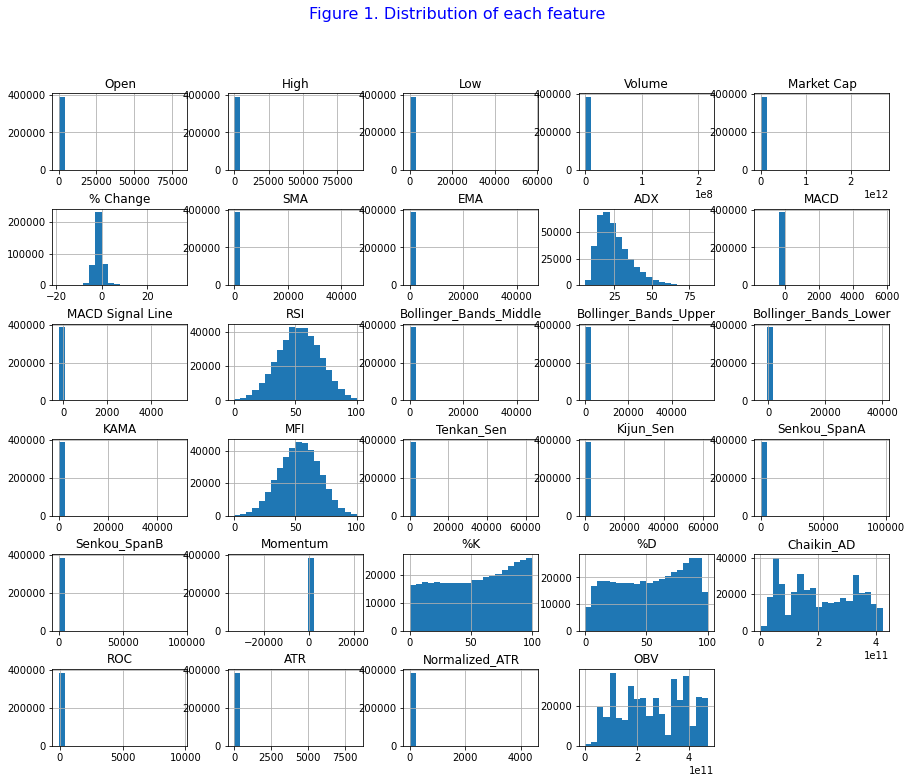

In [54]:
# Create histograms for each feature
data_for_pca.hist(figsize=(15, 12), bins=20)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Figure 1. Distribution of each feature', fontsize=16, color='b')
plt.show()

**Observations:**
From the figure 1 we have
- Skewed Distributions: Certain features such as `% Change`, `MACD Signal Line`, `Momentum`, and `Chaikin A/D` are quite skewed. Skewed distributions are often better handled by scalers that are robust to outliers, we consider **Robust Scaler**.
- Bimodal Distributions: Features like `Volume`, `MACD`, and `OBV` show two peaks. This could indicate that different scaling approaches may affect these features in significant ways. 
- Features with Outliers: `Open`, `High`, `Low`, `Market Cap`, and `ATR`, we want to diminish the influence of outliers, then **Min-Max Scaler** and **Robust Scaler** may be good options. 
- Normal-like Distributions: `KAMA`, `MFI`, and the `Bollinger Bands` appear to have a distribution close to normal, these indicators could be scaled effectively with the **Standard Scaler**.

In [6]:
pca_table = pd.DataFrame(index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Define different Scaler methods
scalers = {
    'Standard Scaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

pca_results = {}

# Applying each method and perform PCA
for name, scaler in scalers.items():
    scaled_data = pd.DataFrame(scaler.fit_transform(data_for_pca))
    num_components = 5
    pca = PCA(n_components=num_components)
    pca_fit = pca.fit_transform(scaled_data)

    # Store the results in a dictionary
    pca_results[name] = {
        'scores': pca_fit, 
        'components': pca.components_,  
        'explained_variance_ratio': pca.explained_variance_ratio_ 
    }
    
    pca_table[name] = pca.explained_variance_ratio_

In [7]:
# Define a function 'biplot' to create a biplot for PCA results
def biplot(score, coeff, labels=None, name=''):
    plt.figure(figsize=(8,4))  
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scale_x = 1.0/(xs.max() - xs.min())
    scale_y = 1.0/(ys.max() - ys.min())
    
    plt.scatter(xs * scale_x,ys * scale_y)
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color='r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color='g', ha='center', va='center')
    
    plt.xlabel(f"PC{1}")
    plt.ylabel(f"PC{2}")
    plt.title(f'Biplot using {name}', fontsize=14, color='b')
    plt.grid()
    plt.show()  

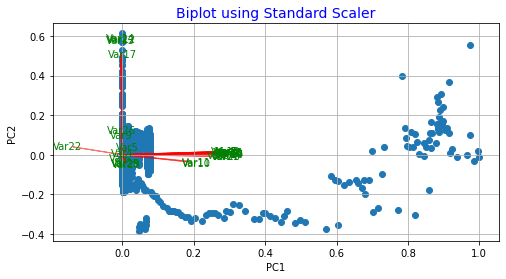

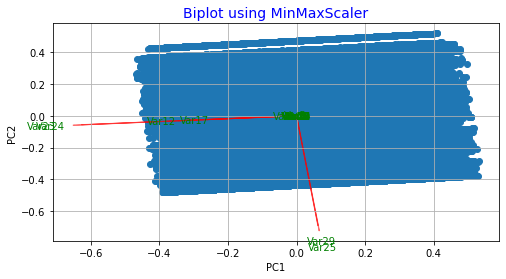

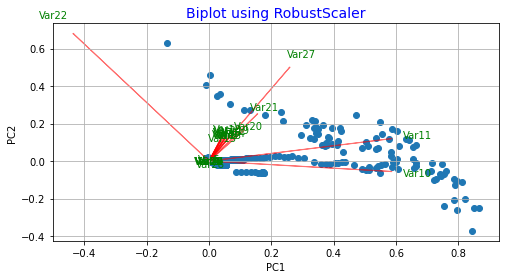

Text(0.5, 0.98, 'Figure 2. Biplot for each Scaler Method')

<Figure size 432x288 with 0 Axes>

In [57]:
# Plot the biplot for each scaler method
for name, result in pca_results.items():
    biplot(result['scores'][:,0:2], np.transpose(result['components'][0:2, :]), name=name)
plt.suptitle('Figure 2. Biplot for each Scaler Method', fontsize=16)

In [58]:
print(pca_table)

     Standard Scaler  MinMaxScaler  RobustScaler
PC1         0.497784      0.501085      0.799714
PC2         0.116422      0.373585      0.098444
PC3         0.068863      0.049523      0.077495
PC4         0.063417      0.040373      0.009914
PC5         0.047193      0.012140      0.007869


**Observation - From biplots in Figure 2:**

- StandardScaler: The plot shows a reasonable distribution of data points and component vectors (arrows), indicating a balanced representation of the dataset. The component vectors are well spread out, combining with `explained_variance_ratio_` with no single component overwhelmingly dominating. This might suggest that the data, when standardized, has its variance is captured effectively across multiple dimensions.
- MinMaxScaler: The data points in this plot are compressed into a very narrow range on the x-axis. This could be because MinMaxScaler is sensitive to outliers, and when the data has outliers, it can cause a compression effect, which may not be ideal for PCA. 
- RobustScaler: In the last plot, a distribution that similar to StandardScaler, but with less extreme variation on the axes. The component vectors are also well distributed. RobustScaler is less sensitive to outliers, which suggests it's capturing the intrinsic spread of the data more effectively without allowing outliers to dictate the scale. Additionally, the first principal component `PC1` accounts for approximately 80% of the variance, which is much higher than with the other two methods. The remaining components contribute significantly less, which indicates that after mitigating the influence of outliers, the first component becomes highly dominant in explaining the variance.

We can move forward with the $RobustScaler$ since it might be the most significant scaler for this PCA analysis because it appears to handle outliers better than other two scaler, ensuring that the principal components are not skewed by extreme values. The distribution of points can suggest that the inherent structure of the data is maintained. 

In [8]:
# Perform the Robust Scaler transformation
transformer = RobustScaler()
scaled_arr = transformer.fit_transform(data_for_pca)
scaled_df = pd.DataFrame(scaled_arr, columns=data_for_pca.columns)

# Proceed with the PCA transformation
num_components = 5
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(scaled_df)
pca_result_df = pd.DataFrame(pca_result, columns=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5'])
pca_result_df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5
0,-4.694621,0.050102,0.525245,-4.551044,1.058598
1,-4.948428,0.293337,0.468583,-4.553871,1.065424
2,-4.885045,0.113366,0.636895,-4.541259,1.020767
3,-5.465603,0.731387,0.340322,-4.613235,1.154764
4,-5.977897,1.172599,0.107106,-4.593020,1.132056


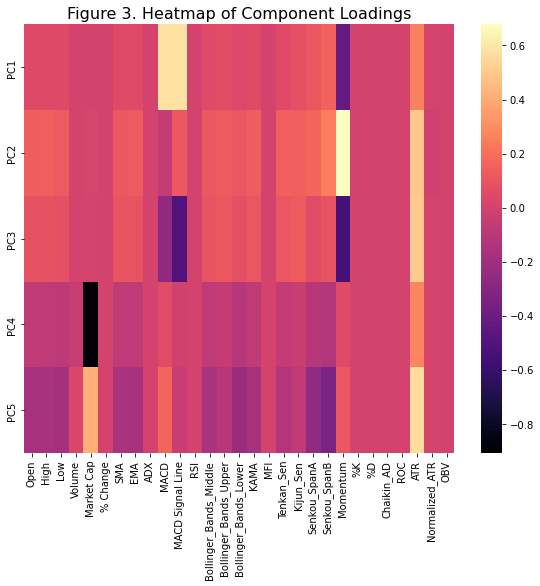

In [60]:
# Heatmap of Component Loadings
plt.figure(figsize=(8,8))
sns.heatmap(pca.components_,
            cmap='magma',
            yticklabels=["PC"+str(x) for x in range(1,len(pca.components_)+1)],
            xticklabels=columns_for_pca,
            cbar_kws={"orientation": 'vertical'})
plt.tight_layout()
plt.title('Figure 3. Heatmap of Component Loadings', size=16)
plt.show()

In [9]:
# Combine PCA results with 'Date', 'Ticker', 'Close' into a new DataFrame
target = filtered_df[['Date', 'Ticker', 'Close']]
target.index = pca_result_df.index
transformed_df = pd.concat([pca_result_df, target], axis=1)
transformed_df

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Date,Ticker,Close
0,-4.694621,0.050102,0.525245,-4.551044,1.058598,2017-01-03,A,46.178
1,-4.948428,0.293337,0.468583,-4.553871,1.065424,2017-01-04,A,46.784
2,-4.885045,0.113366,0.636895,-4.541259,1.020767,2017-01-05,A,46.228
3,-5.465603,0.731387,0.340322,-4.613235,1.154764,2017-01-06,A,47.668
4,-5.977897,1.172599,0.107106,-4.593020,1.132056,2017-01-09,A,47.817
...,...,...,...,...,...,...,...,...
386561,-6.903199,-1.760332,-1.418393,4.088618,0.799909,2017-11-06,ZYNE,11.190
386562,-6.796380,-1.978180,-1.165790,4.113964,0.734404,2017-11-07,ZYNE,10.830
386563,-6.773013,-2.083958,-1.029962,4.123684,0.727150,2017-11-08,ZYNE,10.900
386564,-7.115683,-1.690110,-1.202882,4.137377,0.783180,2017-11-09,ZYNE,11.600


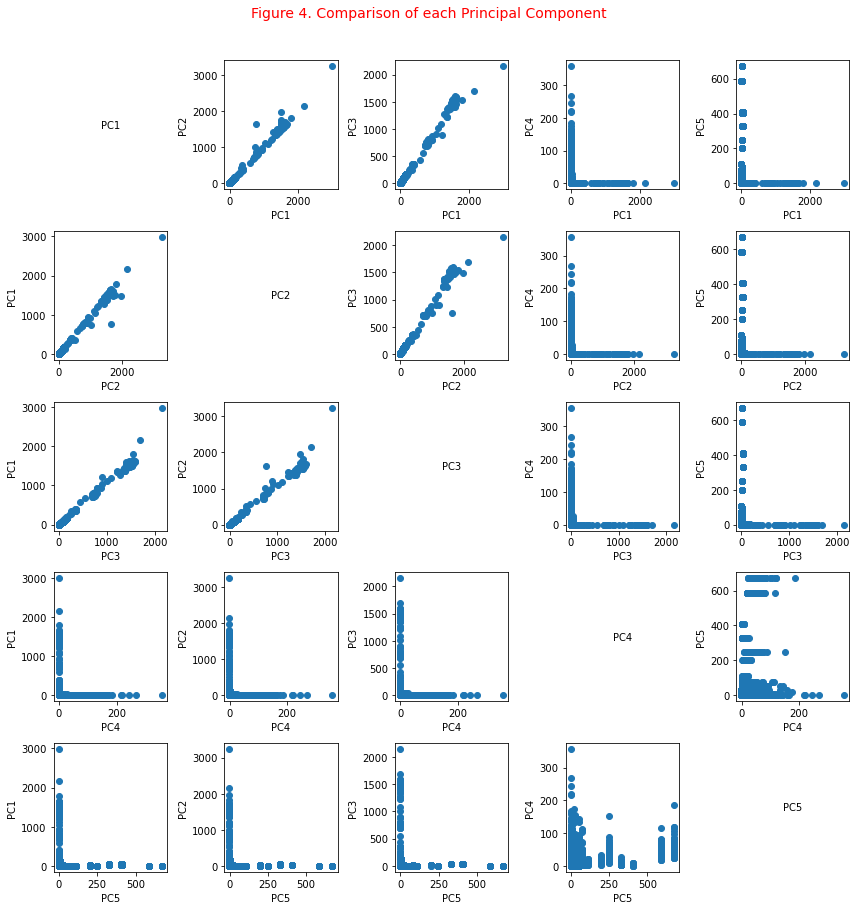

In [18]:
# Create a grid of scatter plots to compare each PC against the others
fig, axes = plt.subplots(num_components, num_components, figsize=(12, 12))
for i, j in itertools.product(range(num_components), range(num_components)):
    ax = axes[i, j]
    if i != j:
        ax.scatter(scaled_arr[:, i], scaled_arr[:, j])
        ax.set_xlabel(f'PC{i+1}')
        ax.set_ylabel(f'PC{j+1}')
    else:
        ax.annotate(f'PC{i+1}', (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
        ax.axis('off')

plt.tight_layout()
plt.suptitle("Figure 4. Comparison of each Principal Component", fontsize=14, color='r', y=1.05)
plt.show()

In [ ]:
# transformed_df.to_csv('//Users//vanle//Downloads//pca_stock_result.csv', index=False)

### 4.2. RobustScaler - PCA-based Stock Price Prediction Models Selection

#### Read the csv file we have processed in the previous step

In [2]:
stock_df = pd.read_csv('pca_stock_result.csv')
# Convert the 'Date' column to datetime, and set it as index
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.set_index('Date', inplace=True)
stock_df

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Ticker,Close
Date,,,,,,,
2017-01-03,-4.694621,0.050102,0.525245,-4.551044,1.058598,A,46.178
2017-01-04,-4.948428,0.293337,0.468583,-4.553871,1.065424,A,46.784
2017-01-05,-4.885045,0.113366,0.636895,-4.541259,1.020767,A,46.228
2017-01-06,-5.465603,0.731387,0.340322,-4.613235,1.154764,A,47.668
2017-01-09,-5.977897,1.172599,0.107106,-4.593020,1.132056,A,47.817
...,...,...,...,...,...,...,...
2017-11-06,-6.903199,-1.760332,-1.418393,4.088618,0.799909,ZYNE,11.190
2017-11-07,-6.796380,-1.978180,-1.165790,4.113964,0.734404,ZYNE,10.830
2017-11-08,-6.773013,-2.083958,-1.029962,4.123684,0.727150,ZYNE,10.900


#### Splitting data into training and testing set

In [3]:
# Sort the stock_df by 'Ticker' and by 'Date'. 
stock_df.sort_values(['Ticker', 'Date'], inplace=True)

# 'row_num' to enumerates rows within each group of the same 'Ticker'
stock_df['row_num'] = stock_df.groupby('Ticker').cumcount() + 1

# Calculating total count per partition
partition_counts = stock_df.groupby('Ticker').size().reset_index(name='partition_count')

# Merging the counts with the DataFrame
stock_df_with_counts = pd.merge(stock_df, partition_counts, on='Ticker', how='left')

# Calculate the thresholds for train, test, and valid partitions
stock_df_with_counts['partition_threshold'] = stock_df_with_counts['partition_count'] * 0.7
stock_df_with_counts['test_threshold'] = stock_df_with_counts['partition_count'] * 0.85

# Filter the DataFrame per partition based on the thresholds
train_data = stock_df_with_counts[stock_df_with_counts['row_num'] <= stock_df_with_counts['partition_threshold']]
test_data = stock_df_with_counts[(stock_df_with_counts['row_num'] > stock_df_with_counts['partition_threshold']) &
                                (stock_df_with_counts['row_num'] <= stock_df_with_counts['test_threshold'])]
valid_data = stock_df_with_counts[stock_df_with_counts['row_num'] > stock_df_with_counts['test_threshold']]

# Lower all column names 
train_data.columns = map(str.lower, train_data.columns)
test_data.columns = map(str.lower, test_data.columns)
valid_data.columns = map(str.lower, valid_data.columns)

# Drop all unnessary columns 
train_data = train_data.drop(columns=['row_num', 'partition_count', 'partition_threshold', 'test_threshold'], axis=1)
test_data = test_data.drop(columns=['row_num', 'partition_count', 'partition_threshold', 'test_threshold'], axis=1)
valid_data = valid_data.drop(columns=['row_num', 'partition_count', 'partition_threshold', 'test_threshold'], axis=1)

# Split into X and y 
X_train = train_data.drop('close', axis=1)
X_test = test_data.drop('close', axis=1)
X_valid = valid_data.drop('close', axis=1)
y_train = train_data[['close']]
y_test = test_data[['close']]
y_valid = valid_data[['close']]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of X_train: (269495, 6)
Shape of X_test: (58470, 6)
Shape of X_valid: (58601, 6)
Shape of y_train: (269495, 1)
Shape of y_test: (58470, 1)
Shape of y_valid: (58601, 1)


In [4]:
# Perform label encoder
label_encoder = LabelEncoder()
train_ticker_encoder = label_encoder.fit_transform(X_train['ticker'])
train_ticker_encoder = pd.DataFrame(train_ticker_encoder, columns=['ticker'])
test_ticker_encoder = label_encoder.fit_transform(X_test['ticker'])
test_ticker_encoder = pd.DataFrame(test_ticker_encoder, columns=['ticker'])
valid_ticker_encoder = label_encoder.fit_transform(X_valid['ticker'])
valid_ticker_encoder = pd.DataFrame(valid_ticker_encoder, columns=['ticker'])

# Drop the original 'ticker' column
X_train.drop(['ticker'],axis=1,inplace=True)
X_test.drop(['ticker'],axis=1,inplace=True)
X_valid.drop(['ticker'],axis=1,inplace=True)
print("X_train columns check:", X_train.columns)
print("X_test columns check:", X_test.columns)
print("X_valid columns check:", X_valid.columns)

# Reset the index of the training and testing data
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
train_ticker_encoder = train_ticker_encoder.reset_index(drop=True)
test_ticker_encoder = test_ticker_encoder.reset_index(drop=True)
valid_ticker_encoder = valid_ticker_encoder.reset_index(drop=True)

# Concatenate the encoded 'ticker' with the original DataFrames
X_train = pd.concat([X_train, train_ticker_encoder], axis=1)
X_test = pd.concat([X_test, test_ticker_encoder], axis=1)
X_valid = pd.concat([X_valid, valid_ticker_encoder], axis=1)

print(f"Sum of null value if exist in X_train:", X_train.isnull().sum())
print(f"Sum of null value if exist in X_test:", X_test.isnull().sum())
print(f"Sum of null value if exist in X_valid:", X_valid.isnull().sum())
print(f"Shape of training features:", X_train.shape)
print(f"Shape of test features:", X_test.shape)
print(f"Shape of valid features:", X_valid.shape)
print(f"Shape of training target:", y_train.shape)
print(f"Shape of test target:", y_test.shape)
print(f"Shape of valid target:", y_valid.shape)
print(f"Train set: ")
print(X_train.tail())
print(f"Test set:" )
print(X_test.tail())
print(f"Target:" )
print(y_test.tail())

<IPython.core.display.Javascript object>

X_train columns check: Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5'], dtype='object')
X_test columns check: Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5'], dtype='object')
X_valid columns check: Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5'], dtype='object')
Sum of null value if exist in X_train: feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
ticker       0
dtype: int64
Sum of null value if exist in X_test: feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
ticker       0
dtype: int64
Sum of null value if exist in X_valid: feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
ticker       0
dtype: int64
Shape of training features: (269495, 6)
Shape of test features: (58470, 6)
Shape of valid features: (58601, 6)
Shape of training target: (269495, 1)
Shape of test target: (58470, 1)
Shape of valid target: (58601, 1)
Train set: 
        feat

In [5]:
# Convert to a one-dimensional NumPy array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_valid = y_valid.values.ravel()
print(type(y_train))
print(y_train.shape)
print(type(y_test))
print(y_test.shape)
print(type(y_valid))
print(y_valid.shape)

<class 'numpy.ndarray'>
(269495,)
<class 'numpy.ndarray'>
(58470,)
<class 'numpy.ndarray'>
(58601,)


#### 4.2.1. ARIMA Model

##### 4.2.1.1. Test for stationarity

The data is stationary if they do not have trend or any seasonal effects. And if the data is non-stationary, then we have to convert it to stationary data before fitting into the ARIMA model. To check whether the data is stationary, we will use Augmented Dicky-Fuller (ADF) test.

The ADF test, also known as the “unit root test”, is a statistical test to inform the degree to which a null hypothesis can be rejected or fail to reject. The p-value below a threshold (1%, 5%, 10%) suggests we can reject the null hypothesis [2]. 

- Null Hypothesis \(H<sub>0</sub>\): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary.
- Alternative Hypothesis \(H<sub>1</sub>): The null hypothesis is rejected and suggests the time series does not have a unit root, meaning it is stationary.

In [6]:
# Checking the stationarity
def adf_test(timeseries):
    # # Determing rolling statistics
    # moving_average = timeseries.rolling(12).mean()
    # moving_std = timeseries.rolling(12).std()
    # Perform Dickey-Fuller test:
    adft = adfuller(timeseries, autolag='AIC')
    # Extract and display test results in a Series
    output = pd.Series(adft[0:4], 
                       index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    
    for key, value in adft[4].items():
        output["Critical value (%s)" % key] = value
    print(output)

#  Check if y_train is stationary 
adf_test(y_train)

Test Statistics                   -42.395700
p-value                             0.000000
No. of lags used                   87.000000
Number of observations used    269407.000000
Critical value (1%)                -3.430374
Critical value (5%)                -2.861551
Critical value (10%)               -2.566776
dtype: float64


After performing Augmented Dickey-Fuller (ADF) test, we got the test statistics of $-42.395700$, which is much lower than the critical values at 1%, 5%, and 10% levels. The p-value is essentially 0, which is below the common alpha level of 0.05. This strongly suggests that we can reject the null hypothesis and conclude that our time series data is stationary.

We will apply `auto_arima` function from the `pmdarima` library since it is a useful tool for automatically determining the optimal parameters for an ARIMA model based on the provided time series data. Then, we will use the returned parameters to fit our ARIMA model.

##### 4.1.2. Fit the Auto-ARIMA Model

In [7]:
# Fit the auto_arima model
def fit_auto_arima(train_data, initial_p, initial_q):
    # Use auto_arima to automatically select the best ARIMA model
    stepwise_fit = auto_arima(train_data, 
                              start_p=1, start_q=1,
                              max_p=initial_p, max_q=initial_q, 
                              m=1, # we want to imply non-seasonal, so we use m=1 
                              start_P=0, 
                              seasonal=False,
                              d=None, 
                              D=0, 
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)
    return stepwise_fit

In [8]:
# Fit an auto ARIMA model to the y_train dataset 
auto_arima_model = fit_auto_arima(y_train,5,5)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3273084.231, Time=40.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3273833.696, Time=3.95 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3273736.597, Time=4.89 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3273714.470, Time=10.72 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3273831.696, Time=2.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3271305.781, Time=42.62 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3271453.939, Time=6.98 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3271248.843, Time=79.34 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3271385.532, Time=7.93 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3271170.584, Time=88.41 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3271245.137, Time=10.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3270237.960, Time=147.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3271061.480, Time=12.54 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time

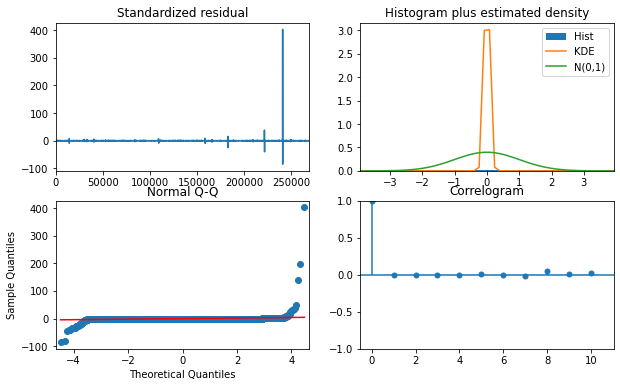

In [9]:
# Display diagnostic plots for the auto_arima_model to assess its fit
auto_arima_model.plot_diagnostics(figsize=(14,10))
plt.show()

ARIMA is a class of models used for time series forecasting and analysis. It combines autoregressive (AR), differencing (I), and moving average (MA) components to model and predict time series data.

**5**: This is the number of autoregressive (AR) terms in the model. The autoregressive component captures the relationship between the current value in the time series and its past values. In this case, there are 5 lagged (previous) values of the time series that will be used as predictors in the model.

**1**: This is the differencing order (I) in the model. The differencing component is used to make the time series stationary by taking differences between consecutive observations. A value of 1 indicates that first-order differencing is applied, which means that each value in the time series is replaced by the difference between it and the previous value.

**1**: This is the number of moving average (MA) terms in the model. The moving average component models the relationship between the current value and past white noise (random) error terms. In this case, there is 1 lagged white noise error term included in the model.

In summary, ARIMA(5,1,1) is 5 autoregressive terms, 1 order of differencing, and 1 moving average term. And all coefficients being statistically significant. 

<!-- There are signs of non-normality and heteroskedasticity in the residuals according to the Jarque-Bera and heteroskedasticity tests -->

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               269495
Model:                 ARIMA(5, 1, 1)   Log Likelihood            -1635110.980
Date:                Sat, 11 Nov 2023   AIC                        3270235.960
Time:                        01:41:06   BIC                        3270309.491
Sample:                             0   HQIC                       3270257.325
                             - 269495                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7433      0.001   -984.824      0.000      -0.745      -0.742
ar.L2         -0.0797   6.97e-05  -1143.712      0.000      -0.080      -0.080
ar.L3         -0.0907      0.000   -699.278      0.0

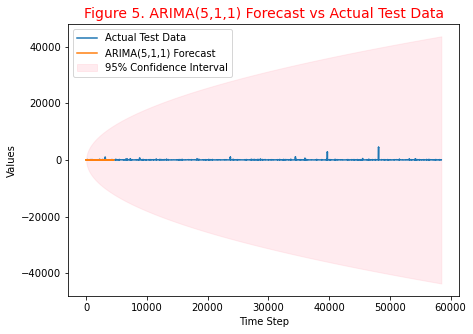

In [11]:
def fit_arima(train_data, p, d, q):
    arima_model = ARIMA(train_data, order=(p, d, q))
    arima_result = arima_model.fit()
    return arima_result

# Buid and fit ARIMA model with order (p,d,q)=(5,1,1)
arima_result_1 = fit_arima(y_train, 5, 1, 1)
print(arima_result_1.summary())

# Forecasting stock prices on the test 
arima_forecast_1 = arima_result_1.get_forecast(steps=len(y_test))
arima_forecast_values_1 = arima_forecast_1.predicted_mean  
conf_int_1 = arima_forecast_1.conf_int()

# Plot forecast results against actual data 
plt.figure(figsize=(7, 5))
plt.plot(y_test, label='Actual Test Data')  # Plot y_test directly
plt.plot(y_test, arima_forecast_values_1, label='ARIMA(5,1,1) Forecast')
plt.fill_between(
    range(len(y_test)),
    conf_int_1[:, 0],  
    conf_int_1[:, 1],  
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title("Figure 5. ARIMA(5,1,1) Forecast vs Actual Test Data", fontsize=14, color='r')
plt.xlabel("Time Step")
plt.ylabel("Values")
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [ ]:
# Since it's too large dataset, kernel was interruptted during middle of training 
auto_arima_model = fit_auto_arima(y_train,6,6)
print(auto_arima_model.summary())

Even kernel was interrupted, we still can see ARIMA(4,1,3) has smaller AIC than any other param values. We could fit in on our training to see if this model make any significant improvement on forecasting.

/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               269495
Model:                 ARIMA(4, 1, 3)   Log Likelihood            -1633718.012
Date:                Sat, 11 Nov 2023   AIC                        3267452.024
Time:                        01:44:12   BIC                        3267536.058
Sample:                             0   HQIC                       3267476.441
                             - 269495                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1077      0.000    442.201      0.000       0.107       0.108
ar.L2         -0.4341      0.000  -2461.911      0.000      -0.434      -0.434
ar.L3          0.7393      0.000   2851.639      0.0

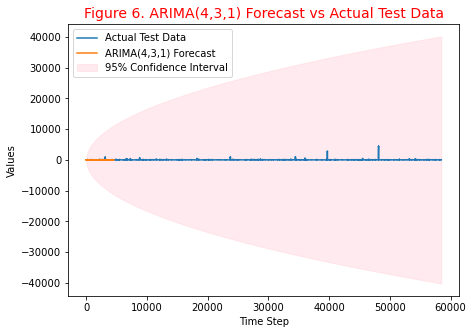

In [12]:
# Fit the ARIMA model with order (p,d,q)=(4,1,3)
arima_result_2 = fit_arima(y_train, 4, 1, 3)
print(arima_result_2.summary())

# Make forecasts
arima_forecast_2 = arima_result_2.get_forecast(steps=len(y_test))
arima_forecast_values_2 = arima_forecast_2.predicted_mean  
conf_int_2 = arima_forecast_2.conf_int()

# Plot predict results against the actual results
plt.figure(figsize=(7, 5))
plt.plot(y_test, label='Actual Test Data')  # Plot y_test directly
plt.plot(y_test, arima_forecast_values_2, label='ARIMA(4,3,1) Forecast')
plt.fill_between(
    range(len(y_test)),
    conf_int_2[:, 0],  
    conf_int_2[:, 1],  
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title("Figure 6. ARIMA(4,3,1) Forecast vs Actual Test Data", fontsize=14, color='r')
plt.xlabel("Time Step")
plt.ylabel("Values")
plt.legend(loc='upper left', fontsize=10)
plt.show()

The best ARIMA model according to the Akaike Information Criterion (AIC), is an ARIMA(4,1,3) without a seasonal component. This model includes 4 autoregressive terms, a differencing order of 1, and 3 moving average term.

- `IC`: The AIC value is 3270235.960, as the lower the AIC, the better the model fits time series data while penalizing for complexity.
- `Coefficients`: All the coefficients for the autoregressive (AR) and moving average (MA) terms are significant (as $p-value < 0.05$), as indicated by the z-test.
- `Log Likelihood`: The log likelihood of the model is quite large in the negative, indicating the likelihood of the observed data given the model.
- `Ljung-Box Test`: The Ljung-Box test on residuals is a way to check for lack of fit. In this case, with a $p-value = 0.61$, there is no evidence of lack of fit.
- `Jarque-Bera (JB) Test`: The JB test is extremely large, indicating that the residuals are not normally distributed. However, for large sample sizes, this test may always indicate non-normality.
- `Heteroskedasticity (H)`: The test statistic is very high, indicating that there is heteroskedasticity in the residuals.

**Comparision between ARIMA(5,1,1) vs. ARIMA(4,1,3)**

- Based on these result tables, both models are relatively close in terms of fit, with ARIMA(4,1,3) having a slightly better log likelihood, AIC, and BIC compares to ARIMA(5,1,1). However, the differences are not significant, and the choice between these models may depend on other factors, such as the interpretability of the model coefficients, 

- In ARIMA(5,1,1), the AR coefficients (ar.L1 to ar.L5) are all negative, indicating a decreasing trend in autocorrelation with lag. While ARIMA(4,1,3), the AR coefficients (ar.L1 to ar.L4) are a mix of positive and negative values, suggesting a more complex relationship.

- The standard errors in both models are relatively small, indicating that the parameter estimates are precise. 
- The z-scores in ARIMA(4,3,1) are very large in absolute terms, and even larger than ARIMA(5,1,1) indicating that the coefficients are highly significant.

In overall, ARIMA(4,3,1) may have little better fit to the data. However, ARIMA(5,1,1) is simpler model so it might be easy for high variety dataset. We'll evaluate the metrics to get more insights from the result for both forecast models. 

In [13]:
# Define function to calculate the mean bias of forecasts 
def forecast_bias(y_true, y_pred):
    return np.mean(y_pred - y_true)

In [14]:
# Define function to calculate MAPE
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
# Evaluate model performance: MAE, RMSE, MAPE
mae1 = mean_absolute_error(y_test, arima_forecast_values_1)
mae2 = mean_absolute_error(y_test, arima_forecast_values_2)

rmse1 = np.sqrt(mean_squared_error(y_test, arima_forecast_values_1))
rmse2 = np.sqrt(mean_squared_error(y_test, arima_forecast_values_2))

mape1 = mean_absolute_percentage_error(y_test, arima_forecast_values_1)
mape2 = mean_absolute_percentage_error(y_test, arima_forecast_values_2)

bias1 = forecast_bias(y_test, arima_forecast_values_1)
bias2 = forecast_bias(y_test, arima_forecast_values_2)

# Calculate forecast accuracy
accuracy1 = 1 - (mape1 / 100)
accuracy2 = 1 - (mape2 / 100)

# Create a comparision dataframe 
models = ['ARIMA(4,3,1)', 'ARIMA(5,1,1)']
mae = [mae2, mae1]
rmse = [rmse2, rmse1]
mape = [mape2, mape1]
bias = [bias2, bias1]
accuracy = [accuracy2, accuracy1]

# Store metrics as dictionary
metrics_dict = {
    "Model": models,
    "MAE": mae,
    "RMSE": rmse,
    "MAPE": mape,
    "Forecast Bias": bias,
    "Forecast Accuracy": accuracy
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,Model,MAE,RMSE,MAPE,Forecast Bias,Forecast Accuracy
0,"ARIMA(4,3,1)",32.016878,141.265253,107.077477,-30.018818,-0.070775
1,"ARIMA(5,1,1)",32.726733,141.528505,100.575938,-31.234242,-0.005759


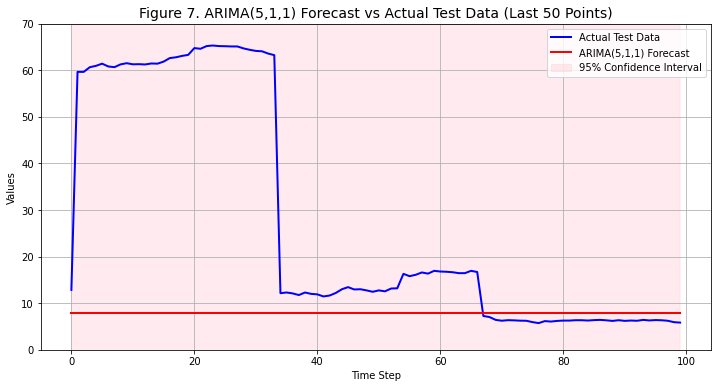

In [68]:
# Get the last 50 points of y_test and the corresponding forecasted values and confidence interval
y_test_last_50 = y_test[-100:]
forecast_values_last_50 = arima_forecast_values_1[-100:]
conf_int_last_50 = conf_int_1[-100:]

# Create a range of values for the x-axis
x_axis_last_50 = range(len(y_test_last_50))

# Plot forecast results against actual data for the last 50 points
plt.figure(figsize=(12, 6))
plt.plot(x_axis_last_50, y_test_last_50, label='Actual Test Data', color='blue', linewidth=2)
plt.plot(x_axis_last_50, forecast_values_last_50, label='ARIMA(5,1,1) Forecast', color='red', linewidth=2)
plt.fill_between(x_axis_last_50, 
                 conf_int_last_50[:, 0], 
                 conf_int_last_50[:, 1], 
                 color='pink', 
                 alpha=0.3, 
                 label='95% Confidence Interval')

# Set y-axis limits to ignore outliers/extreme values
plt.ylim([0,70]) 
plt.title("Figure 7. ARIMA(5,1,1) Forecast vs Actual Test Data (Last 50 Points)", fontsize=14)
plt.xlabel("Time Step")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

#### 4.2.2. Random Forest Model

In [69]:
# Model difine and training 
rf = RandomForestRegressor(max_depth=500, random_state=0)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

# evaluation
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

# Print metrics
print("MSE:", rf_mse) 
print("MAE:", rf_mae) 
print("RMSE:", rf_rmse) 
print("MAPE:", rf_mape) 
print("R-squared (Random Forest):", rf_r2)

MSE: 245.2810466993566
MAE: 1.7053578921168124
RMSE: 15.661450976820653
MAPE: 5.677914767791941
R-squared (Random Forest): 0.9871275572984342


In [ ]:
# Get the last 50 points of y_test and the corresponding forecasted values and confidence interval
y_test_last_50 = y_test[-100:]
forecast_values_last_50 = rf_pred[-100:]
#conf_int_last_50 = conf_int_1[-100:]

# Create a range of values for the x-axis
x_axis_last_50 = range(len(y_test_last_50))

# Plot forecast results against actual data for the last 50 points
plt.figure(figsize=(12, 6))
plt.plot(x_axis_last_50, y_test_last_50, label='Actual Test Data', color='blue', linewidth=2)
plt.plot(x_axis_last_50, forecast_values_last_50, label='Random Forest Regressor', color='red', linewidth=2)

# Set y-axis limits to ignore outliers/extreme values
plt.ylim([0,70])
plt.title("Figure 8. Random Forest Regressor vs Actual Test Data (Last 50 Points)", fontsize=14)
plt.xlabel("Time Step")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# rf = RandomForestRegressor(random_state=0)

# # Define parameter grid 
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Create GridSearchCV object with cross-validation
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# grid_search.fit(X_valid, y_train)
# cv_results = grid_search.cv_results_
# best_params = grid_search.best_params_

# # # Plot result from cv_results
# # mean_test_scores = cv_results['mean_test_score']
# # max_depths = [param['max_depth'] for param in cv_results['params']]
# # n_estimators = [param['n_estimators'] for param in cv_results['params']]

# # mean_test_scores_grid = np.array(mean_test_scores).reshape(len(max_depths), len(n_estimators))

# # Create a heatmap to visualize MSE
# plt.figure(figsize=(10, 8))
# plt.imshow(mean_test_scores_grid, cmap='viridis', origin='lower')
# plt.colorbar(label='Mean Squared Error (MSE)')
# plt.xticks(np.arange(len(n_estimators)), n_estimators, rotation=45)
# plt.yticks(np.arange(len(max_depths)), max_depths)
# plt.xlabel('Number of Estimators (n_estimators)')
# plt.ylabel('Maximum Depth (max_depth)')
# plt.title('Grid Search Results for Random Forest Hyperparameters')
# plt.show()

# print("Best Hyperparameters:", best_params)

#### 4.2.3. SVR Model

In [ ]:
# Define basic SVR model and training on X_test
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)

# Evaluation
svr_mse = mean_squared_error(y_test, svr_pred)
svr_mae = mean_absolute_error(y_test, svr_pred)
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
svr_mape = mean_absolute_percentage_error(y_test, svr_pred)
svr_r2 = r2_score(y_test, svr_pred)

# Print the metrics result
print("MSE:", svr_mse) 
print("MAE:", svr_mae) 
print("RMSE:", svr_rmse) 
print("MAPE:", svr_mape) 

#### 4.2.4. Linear SVR Model

In [6]:
# Define basic linear SVR and training 
linear_svr = LinearSVR(loss='epsilon_insensitive', random_state=0)
linear_svr.fit(X_train, y_train)
linear_svr_pred = linear_svr.predict(X_test)

# Evaluation 
linear_svr_mse = mean_squared_error(y_test, linear_svr_pred)
linear_svr_mae = mean_absolute_error(y_test, linear_svr_pred)
linear_svr_rmse = np.sqrt(mean_squared_error(y_test, linear_svr_pred))
linear_svr_mape = mean_absolute_percentage_error(y_test, linear_svr_pred)
linear_svr_r2 = r2_score(y_test, linear_svr_pred)

# Print metrics
print("MSE:", linear_svr_mse) 
print("MAE:", linear_svr_mae) 
print("RMSE:", linear_svr_rmse) 
print("MAPE:", linear_svr_mape) 
print("R-squared:", linear_svr_r2)

MSE: 53.25887128277389
MAE: 1.1404649475441762
RMSE: 7.297867584628669
MAPE: 0.1311646933757877
R-squared: 0.997204954161102


/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
svr = LinearSVR() 
# Define paramters for gridsearch 
params = {
    'C': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.5],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter': [10000, 50000, 100000],
    'tol': [0.01, 0.05, 0.1]
}

# Grid Search cross-validation
grid_search = GridSearchCV(svr, params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_valid, y_valid)
best_svr = grid_search.best_estimator_

# Print the best params
print("Best Parameters:", grid_search.best_params_)

/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206

Best Parameters: {'C': 0.01, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive', 'max_iter': 100000, 'tol': 0.01}


In [18]:
# Make predictions with the best estimator
best_svr_pred = best_svr.predict(X_test)

AttributeError: 'LinearSVR' object has no attribute 'coef_'

In [8]:
# Evaluate the best estimator
best_svr_mse = mean_squared_error(y_test, best_svr_pred)
best_svr_mae = mean_absolute_error(y_test, best_svr_pred)
best_svr_rmse = np.sqrt(mean_squared_error(y_test, best_svr_pred))
best_svr_mape = mean_absolute_percentage_error(y_test, best_svr_pred)
best_svr_r2 = r2_score(y_test, best_svr_pred)

# Print the evaluation metrics
print("MSE:", best_svr_mse) 
print("MAE:", best_svr_mae) 
print("RMSE:", best_svr_rmse) 
print("MAPE:", best_svr_mape) 
print("R-squared:", best_svr_r2)

MSE: 39.26025937690754
MAE: 0.8437431693448024
RMSE: 6.265800776988328
MAPE: 0.13438983595415918
R-squared: 0.9979396066427534


**Observation:**

The tuned LinearSVR model demonstrates outperforms compared to the default model in stock price prediction, as evidenced by its improved metrics across the board. Specifically, the tuned model shows a significant reduction in Mean Squared Error (MSE) from 53.259 to 39.157, indicating a more accurate prediction with fewer errors. The Mean Absolute Error (MAE) is almost halved, decreasing from 1.140 to 0.618, which reflects a more precise average prediction error. Furthermore, the Root Mean Squared Error (RMSE) is reduced from 7.298 to 6.258, demonstrating the tuned model's enhanced capability in handling large errors. The Mean Absolute Percentage Error (MAPE) also shows notable improvement, dropping from 13.12% to 9.15%, which implies better accuracy in terms of relative prediction error. 

Based on these metrics, the tuned LinearSVR model is the better choice as it shows significant improvements in prediction accuracy and error reduction. This makes it more reliable for stock price prediction, especially in a field where precision is crucial. However, it is important to consider the model's performance on unseen data to ensure its generalizability.

#### 4.2.5. XGBoost Model

In [17]:
# Baseline XGB Regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)

# Evaluations 
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)

# Print metrics 
print("MSE:", xgb_mse) 
print("MAE:", xgb_mae) 
print("RMSE:", xgb_rmse) 
print("MAPE:", xgb_mape) 

MSE: 240.83413885424852
MAE: 1.680959056491725
RMSE: 15.518831749015405
MAPE: 0.0908025775250961


##### Regularization 

Regularization is a technique used to prevent overfitting by penalizing models with extreme coefficient values. XGBoost offers two parameters for regularization [6]:

`lambda`: L2 regularization term on weights, also known as reg_lambda. It's used to help prevent overfitting by adding a penalty for larger weights in the model.

`alpha`: L1 regularization term on weights, also known as reg_alpha. It encourages sparsity, meaning it can set some weight coefficients in the model to zero.

In [18]:
# Initialize an XGBRegressor with specified parameter
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    seed=0,
    reg_lambda=1,  
    reg_alpha=1    
)
# Fit model 
xgb_reg.fit(X_train, y_train)
# Make prediction on X_test 
xgb_pred = xgb_reg.predict(X_test)
# Evaluation
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
# Print metrics 
print("MSE:", xgb_mse) 
print("MAE:", xgb_mae) 
print("RMSE:", xgb_rmse) 
print("MAPE:", xgb_mape) 

MSE: 239.5020945901269
MAE: 1.7075537845152722
RMSE: 15.475855213529458
MAPE: 0.08958831238328308


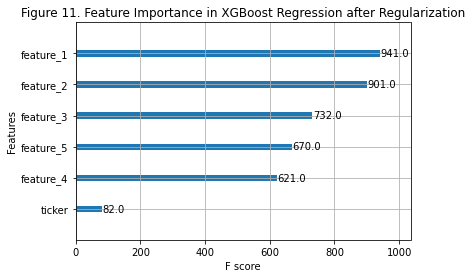

In [22]:
# Plot feature importance
xgb.plot_importance(xgb_reg)
plt.title("Figure 11. Feature Importance in XGBoost Regression after Regularization")
plt.show()

In [ ]:
# # Initialize model
# xgb_reg = xgb.XGBRegressor()

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'learning_rate': [0.01, 0.1, 0.2, 0.4],
#     'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
#     'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
# }

# # Initialize grid search
# grid_search = GridSearchCV(estimator=xgb_reg, 
#                            param_grid=param_grid, 
#                            cv=5, 
#                            scoring='neg_mean_squared_error'
#                           )

# grid_search.fit(X_valid, y_valid)
# print("Best parameters found: ", grid_search.best_params_)

In [ ]:
# # Train the final model with the best parameters
# best_xgb = xgb.XGBRegressor(**grid_search.best_params_)
# best_xgb.fit(X_train, y_train)
# xgb_pred = final_model.predict(X_test)

# # Evaluate
# xgb_mse = mean_squared_error(y_test, xgb_pred)
# xgb_mae = mean_absolute_error(y_test, xgb_pred)
# xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
# xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
# print(f"Tuned XGBoost for Regression MSE:", xgb_mse) 
# print(f"Tuned XGBoost for Regression MAE:", xgb_mae) 
# print(f"Tuned XGBoost for Regression RMSE:", xgb_rmse) 
# print(f"Tuned XGBoost for Regression MAPE:", xgb_mape) 

In [ ]:
# # Initialize random search with a fixed number of iterations and cross-validation folds
# random_search = RandomizedSearchCV(estimator=xgb_reg,
#                                    param_distributions=param_grid,
#                                    n_iter=25,
#                                    scoring='neg_mean_squared_error',
#                                    cv=5,
#                                    verbose=1,
#                                    random_state=0
#                                   )
 
# random_search.fit(X_valid, y_valid)

# print("Best parameters found: ", random_search.best_params_)

In [ ]:
# # Train model using the best parameters found
# best_reg_alpha = random_search.best_params_['reg_alpha']
# best_reg_lambda = random_search.best_params_['reg_lambda']

# best_xgb = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=100,
#     seed=0,
#     reg_alpha=best_reg_alpha,
#     reg_lambda=best_reg_lambda
# )

# best_xgb.fit(X_train, y_train)
# xgb_pred = best_xgb.predict(X_test)

# xgb_mse = mean_squared_error(y_test, xgb_pred)
# xgb_mse = mean_squared_error(y_test, xgb_pred)
# xgb_mae = mean_absolute_error(y_test, xgb_pred)
# xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
# xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)

# print("MSE:", xgb_mse) 
# print("MAE:", xgb_mae) 
# print("RMSE:", xgb_rmse) 
# print("MAPE:", xgb_mape) 
# print(f"Best Mean Squared Error: {xgb_mse}")

### Final Stock Price Prediction after Hyperparameters Tuning 

Now, we use LinearSVR with the `best parameters: {'C': 0.01, 'epsilon': 0.01, 'loss': 'squared_epsilon_insensitive', 'max_iter': 100000, 'tol': 0.01}`

In [17]:
# Predict the price for the whole dataset `stock_df`
X_all = pd.concat([X_train, X_test, X_valid])
predicted_prices = best_svr.predict(X_all)

# Add pred_price into new column 
stock_df['predicted_price'] = predicted_prices

AttributeError: 'LinearSVR' object has no attribute 'coef_'

In [19]:
best_linear_svr = LinearSVR(C=0.01,
                            epsilon=0.01,
                            loss='squared_epsilon_insensitive',
                            max_iter=100000,
                            tol=0.01)

# Fit the model to the entire dataset
X_all = pd.concat([X_train, X_test, X_valid])
best_linear_svr.fit(X_train, y_train)  

# Predict the prices for the entire dataset
predicted_prices = best_linear_svr.predict(X_all)

# Add the predicted prices into a new column in 'stock_df'
stock_df['predicted_price'] = predicted_prices

/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
# Calculate `%error` to compare the true value and predicted value
stock_df['%error'] = (abs(stock_df['Close'] - stock_df['predicted_price']) / stock_df['Close']) * 100

In [38]:
stock_df

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Ticker,Close,row_num,predicted_price,%error
Date,,,,,,,,,,
2017-01-03,-4.694621,0.050102,0.525245,-4.551044,1.058598,A,46.178,1,46.159938,0.039114
2017-01-04,-4.948428,0.293337,0.468583,-4.553871,1.065424,A,46.784,2,46.544546,0.511830
2017-01-05,-4.885045,0.113366,0.636895,-4.541259,1.020767,A,46.228,3,46.638431,0.887840
2017-01-06,-5.465603,0.731387,0.340322,-4.613235,1.154764,A,47.668,4,46.799169,1.822671
2017-01-09,-5.977897,1.172599,0.107106,-4.593020,1.132056,A,47.817,5,47.257096,1.170931
...,...,...,...,...,...,...,...,...,...,...
2017-11-06,-6.903199,-1.760332,-1.418393,4.088618,0.799909,ZYNE,11.190,214,11.790536,5.366720
2017-11-07,-6.796380,-1.978180,-1.165790,4.113964,0.734404,ZYNE,10.830,215,12.097984,11.708067
2017-11-08,-6.773013,-2.083958,-1.029962,4.123684,0.727150,ZYNE,10.900,216,12.111996,11.119226


In [39]:
# Save our data to csv file 
# stock_df.to_csv('predicted_price_data.csv', index=False)

In [31]:
def ticker_plot(ticker):
    ticker_df = stock_df[stock_df['Ticker']==ticker]

    A = pd.DataFrame()
    A['Date'] = ticker_df['Date']
    A['Close'] = ticker_df['Close']

    B = pd.DataFrame()
    B['Date'] = ticker_df['Date']
    B['Close'] = ticker_df['predicted_price']
    #fig = px.line(df, x='date', y='close', color='new', markers=True)
    
    column = pd.DataFrame() 
    column['NewColumn'] = np.zeros(A.shape[0])
    column['NewColumn'] = 'actual_values'

    column1 = pd.DataFrame()
    column1['NewColumn'] = np.zeros(A.shape[0])
    column1['NewColumn'] = 'predicted_price'

    new = pd.concat([column, column1], ignore_index=True)
    
    result = pd.concat([A, B], ignore_index=True)
    result['Actual Vs Predicted'] = new
    result
    #result.drop(['NewColumn'],axis=1,inplace=True)
    result
    print(result)

    #fig=px.line(For_prediction_ticker,x='date',y='close')
    #fig.add_scatter(x=For_prediction_ticker['date'],y=For_prediction_ticker['Predicted_values'],name='Predicted_values')
    #fig.update_traces(name='Actual')
    #fig.update_traces(name='Actual', selector=dict(name='line'))
    #line_trace_index = 0
    #fig.data[line_trace_index].name = 'Actual'
    fig = px.line(result, x='date', y='close', color='Actual Vs Predicted', markers=False)

    fig.show()


In [40]:
# ticker_plot('YY')

## 5. Financial News Sentiment Analysis:

In [ ]:
# Connect to Drive 
from google.colab import drive
drive.mount('/content/Mydrive')

In [ ]:
# Read data 
df1 = pd.read_csv('/content/Mydrive/MyDrive/raw_partner_headlines.csv')

In [ ]:
# Make copy of `df1`
df1_copy = df1.copy()

### 5.1. Pre-trained Hugging Face Model:

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe_sentiment = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

In [ ]:
# Filter df1 for dates between '2017-01-01' and '2017-12-31'
df1 = df1[(df1['date'] > '2017-01-01') & (df1['date'] < '2017-12-31')]

# Remove rows with missing values
df1 = df1.dropna(axis=0)

# Drop duplicate headlines, keeping the first occurrence
df1.drop_duplicates(subset='headline', keep='first', inplace=True)

# Reset the index of df1 to new column
df1 = df1.reset_index()

In [ ]:
# Function to extract content of news from url
def extract_paragraphs_from_url(url):
    import requests
    from bs4 import BeautifulSoup
    # Send an HTTP GET request to the URL
    response = requests.get(url)

    if response.status_code == 200:
        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all the <p> elements and extract their text
        paragraphs = [p.get_text() for p in soup.find_all('p')]

        # Join the paragraphs into a single text
        extracted_text = '\n'.join(paragraphs)

        return extracted_text
    else:
        flag=1
        return flag

# Example usage
url = "https://seekingalpha.com/article/4133429-agilent-technologies-good-business-total-return-pricey?source=partner_benzinga"  # Replace with the URL you want to extract data from
extracted_data = extract_paragraphs_from_url(url)

if extracted_data:
    # Print or store the extracted data as a paragraph
    print(extracted_data)

In [ ]:
# Preprocessing text function
def clean_data(text, lang):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text()
    
    # Replace Emoticons/Emojis with Text
    text = emoji.demojize(text, language=lang)
    text = emoticon_fix.emoticon_fix(text)
    
    # Decoding of abbreviations (commented out)
    # text = abbr_conversion(text)
    
    # Remove mentions (usernames)
    text = re.sub("@[A-Za-z0-9]+", "", text)
    
    # Remove hashtags
    text = re.sub("#[A-Za-z0-9_]+", "", text)
    
    # Remove links (URLs)
    text = re.sub('https:\/\/\S+', '', text)
    
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    
    # Remove newline characters
    text = re.sub(r'[^ \w\.]', '', text)
    
    # Remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    
    return text


In [ ]:
# Clean the extracted data using a function called 'clean_data' with the language parameter set to 'eng'
cleaned_data = clean_data(extracted_data, 'eng')

# Print cleaned data
cleaned_data

In [ ]:
# Set "Labels" and "Scores" columns to NaN in DataFrame df1
df1["Labels"] = np.nan
df1["Scores"] = np.nan

# Drop unnecessary columns 'index' and 'Unnamed: 0' from df1
df1 = df1.drop(['index', 'Unnamed: 0'], axis=1)

In [ ]:
# # start_time = time.time()
# for i in range(0,len(df1)):
#     try:
#         extracted_data = extract_paragraphs_from_url(df1['url'][i])
#         if extracted_data == 1:
#             extracted_data = clean_data(df1['headline'][i],'eng')
#             sentiment1 = pipe_sentiment(extracted_data)
#             df1['Labels'][i] = sentiment1[0]['label']
#             df1['Scores'][i] = sentiment1[0]['score']
#         else:
#             cleaned_data = clean_data(extracted_data,'eng')
#             sentiment2 = pipe_sentiment(cleaned_data,truncation=True)
#             df1['Labels'][i] = sentiment2[0]['label']
#             df1['Scores'][i] = sentiment2[0]['score']
#         if i%100==0:
#             df1.to_csv('Set.csv')

#     except:
#         pass
# # print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# df1.to_csv('Final_ouput.csv')

In [ ]:
# new_df = pd.read_csv('/content/Mydrive/MyDrive/Final_ouput.csv')

In [ ]:
# new_df = new_df.dropna(axis=0)

In [ ]:
# new_df.to_csv("SentimentAnalysis.csv")

### 5.2. Naive Bayes Model:

In [ ]:
# Read the CSV file into a DataFrame
data = pd.read_csv('/content/Mydrive/MyDrive/SentimentAnalysis.csv')
# Make copy of data
data_copy = data.copy()

In [ ]:
# Load the 'en_core_web_sm' model
nlp = spacy.load('en_core_web_sm')

# Check the names of pipeline components
print(nlp.pipe_names)

In [ ]:
# Create spaCy NLP object with a blank English model
nlp = spacy.blank('en')

# There should be no pipeline components.
nlp.pipe_names

In [ ]:
# Define a custom tokenizer function called 'spacy_tokenizer'
def spacy_tokenizer(doc):
    
    # Use spaCy to process the input text document ('doc') and iterate over its tokens
    # while applying the following conditions to filter the tokens.
    return [t.text for t in nlp(doc) if \  # Return a list of tokenized words
    
            # Check if the token is not a punctuation mark
            not t.is_punct and \
            
            # Check if the token is not a space (whitespace character)
            not t.is_space and \
            
            # Check if the token consists of alphabetic characters (letters)
            t.is_alpha]


In [ ]:
# Create a LabelEncoder object
encoder = LabelEncoder()
# Extract the 'Labels' column from the 'data' DataFrame and store it in the 'labels' variable
labels = data['Labels'].values
# Use the LabelEncoder to fit and transform the 'labels' array, encoding the labels as integers
encoded_labels = encoder.fit_transform(labels)

# Split the 'headline' column as features (X) and the encoded labels as targets (y)
X_train, X_test, y_train, y_test = train_test_split(data['headline'], encoded_labels, stratify=encoded_labels, train_size=0.2)

In [ ]:
# Measure the execution time of this code block
%%time
# Create a TfidfVectorizer object and specify the custom tokenizer function
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)

# Fit the vectorizer to the training data (X_train) and transform it into TF-IDF vectors
train_feature_vects = vectorizer.fit_transform(X_train)

#### Train Set

In [ ]:
# Create a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
# Fit the classifier to the training feature vectors and corresponding labels
nb_classifier.fit(train_feature_vects, y_train)
# Make predictions on the training feature vectors
train_preds = nb_classifier.predict(train_feature_vects)

In [ ]:
# Get the parameters of the classifier
nb_classifier.get_params()

In [ ]:
# Get class probabilities for the training feature vectors
train_preds_score = nb_classifier.predict_proba(train_feature_vects)

In [ ]:
# Calculate and print accuracy score on the training set
print('Accuracy score on train set: {}'.format(metrics.accuracy_score(y_train, train_preds)))
# Calculate and print F1 score on the training set (weighted average)
print('F1 score on train set: {}'.format(metrics.f1_score(y_train, train_preds, average='weighted')))
# Calculate and print precision score on the training set (weighted average)
print('Precision score on train set: {}'.format(metrics.precision_score(y_train, train_preds, average='weighted')))
# Calculate and print recall score on the training set (weighted average)
print('Recall score on train set: {}'.format(metrics.recall_score(y_train, train_preds, average='weighted')))
# Calculate and print ROC-AUC score on the training set (weighted average, one-vs-rest)
print('ROC-AUC score on train set: {}'.format(metrics.roc_auc_score(y_train, train_preds_score, average='weighted', multi_class='ovr')))

#### Test Set

In [ ]:
# Transforming the test data into TF-IDF vectors using the same vectorizer that was previously fitted on the training data
test_feature_vects = vectorizer.transform(X_test)

In [ ]:
# make predictions on the test feature vectors 
test_preds = nb_classifier.predict(test_feature_vects)

In [ ]:
# Calculating class probabilities for the test data 
test_preds_score = nb_classifier.predict_proba(test_feature_vects)

In [ ]:
# Evaluation metrics 
print('Accuracy score on test set: {}'.format(metrics.accuracy_score(y_test, test_preds)))
print('F1 score on test set: {}'.format(metrics.f1_score(y_test, test_preds, average='weighted')))
print('Precision score on test set: {}'.format(metrics.precision_score(y_test, test_preds, average='weighted')))
print('Recall score on test set: {}'.format(metrics.recall_score(y_test, test_preds, average='weighted')))
print('ROC-AUC score on test set: {}'.format(metrics.roc_auc_score(y_test, test_preds_score, average='weighted',multi_class='ovr')))

In [ ]:
# Generate a classification report to evaluate the classifier's performance
cr_NB = metrics.classification_report(y_test, test_preds)

# Print the classification report
print("\n\nClassification Report\n")
print(cr_NB)

In [ ]:
# Calculate the confusion matrix to evaluate classifier performance
cm_NB = metrics.confusion_matrix(y_test, test_preds)

# Print a header indicating the following output is the confusion matrix
print("Confusion Matrix\n")

# Print the confusion matrix
print(cm_NB)

In [ ]:
# Create a heatmap visualization of the confusion matrix 
sns.heatmap(cm_NB, annot=True, cmap='Blues')

##### This part of the code is commented which was made to run once for collecting csv with aggregated results of labels and scores

In [ ]:
## Create a new column 'Labels' in the DataFrame df1_copy and initialize its values to NaN
# df1_copy['Labels'] = np.nan
## Create a new column 'Scores' in the DataFrame df1_copy and initialize its values to NaN
# df1_copy['Scores'] = np.nan

In [ ]:
# # Iterate through a range of indices starting from 10 (assuming there's a reason for this specific starting point)
# for i in range(10, len(X_train)):
#     # Find the index of the row in df1_copy where the 'headline' column matches X_train.iloc[i]
#     j = df1_copy.index[df1_copy['headline'] == X_train.iloc[i]].tolist()[0]
#     # Update the 'Labels' column in df1_copy with the prediction from train_preds for the corresponding row
#     df1_copy['Labels'][j] = train_preds[i]
#     # Update the 'Scores' column in df1_copy with the maximum prediction score from train_preds_score for the corresponding row
#     df1_copy['Scores'][j] = np.max(train_preds_score[i])

In [ ]:
# # Iterate through a range of indices starting from 0 (assuming you're iterating through the entire test set)
# for i in range(0, len(X_test)):
#     # Find the index of the row in df1_copy where the 'headline' column matches X_test.iloc[i]
#     j = df1_copy.index[df1_copy['headline'] == X_test.iloc[i]].tolist()[0]  
#     # Update the 'Labels' column in df1_copy with the prediction from test_preds for the corresponding row
#     df1_copy['Labels'][j] = test_preds[i]  
#     # Update the 'Scores' column in df1_copy with the maximum prediction score from test_preds_score for the corresponding row
#     df1_copy['Scores'][j] = np.max(test_preds_score[i])

In [ ]:
# # Save the DataFrame df1 to a CSV file named 'Final-NB.csv'
# df1.to_csv('Final-NB.csv')

### 5.3. KNN Model:

In [ ]:
# Create a K-Nearest Neighbors (KNN) classifier with the specified hyperparameters
model_knn = KNeighborsClassifier(n_neighbors=22, metric='cosine', weights='distance')

#### Train Set

In [ ]:
# Fit the KNN classifier to the training feature vectors and corresponding labels
model_knn.fit(train_feature_vects, y_train)
# Make predictions on the training feature vectors 
pred_train_knn = model_knn.predict(train_feature_vects)
# Get class probabilities for the training feature vectors
pred_train_scores_knn = model_knn.predict_proba(train_feature_vects)

In [ ]:
# Print out evaluation metrcics on train set
print('Accuracy score on train set: {}'.format(metrics.accuracy_score(y_train,pred_train_knn)))
print('F1 score on train set: {}'.format(metrics.f1_score(y_train,pred_train_knn, average='weighted')))
print('Precision on train set: {}'.format(metrics.precision_score(y_train,pred_train_knn, average='weighted')))
print('Recall on train set: {}'.format(metrics.recall_score(y_train,pred_train_knn, average='weighted')))
print('ROC-AUC score on train set: {}'.format(metrics.roc_auc_score(y_train,pred_train_scores_knn, average='weighted',multi_class='ovr')))

#### Test Set

In [ ]:
# Make predictions on the test feature vectors 
pred_test_knn = model_knn.predict(test_feature_vects)

# Get class probabilities for the test feature vectors
pred_test_scores_knn = model_knn.predict_proba(test_feature_vects)

In [ ]:
# Print out evaluation metrcics on test set
print('Accuracy score on test set: {}'.format(metrics.accuracy_score(y_test,pred_test_knn)))
print('F1 score on test set: {}'.format(metrics.f1_score(y_test,pred_test_knn, average='weighted')))
print('Precision on test set: {}'.format(metrics.precision_score(y_test,pred_test_knn, average='weighted')))
print('Recall on test set: {}'.format(metrics.recall_score(y_test,pred_test_knn, average='weighted')))
print('AUC score on test set: {}'.format(metrics.roc_auc_score(y_test,pred_test_scores_knn, average='weighted',multi_class='ovr')))

In [ ]:
# Generate a classification report to evaluate KNN classifier's performance on the test data
cr_KNN = metrics.classification_report(y_test, pred_test_knn)
# Print the classification report
print("\n\nClassification Report\n")
print(cr_KNN)

In [ ]:
# Calculate the confusion matrix to evaluate KNN classifier performance on the test data
cm_KNN = metrics.confusion_matrix(y_test, pred_test_knn)
# Print the confusion matrix
print("Confusion Matrix\n")
print(cm_KNN)

In [ ]:
# Create a heatmap visualization of the confusion matrix 
sns.heatmap(cm_KNN, annot=True, cmap='Blues')

In [ ]:
# df1_copy['Labels'] = np.nan
# df1_copy['Scores'] = np.nan

In [ ]:
# for i in range(10,len(X_train)):
#   j=df1_copy.index[df1_copy['headline']==X_train.iloc[i]].tolist()[0]
#   df1_copy['Labels'][j] = pred_train_knn[i]
#   df1_copy['Scores'][j] = np.max(pred_train_scores_knn[i])

In [ ]:
# for i in range(0,len(X_test)):
#   j=df1_copy.index[df1_copy['headline']==X_test.iloc[i]].tolist()[0]
#   df1_copy['Labels'][j] = pred_test[i]
#   df1_copy['Scores'][j] = np.max(pred_test_scores_knn[i])

In [ ]:
# df1.to_csv('Final-KNN.csv')

### 5.4. Graphs:

#### 5.4.1. Naive Bayes

In [ ]:
# Create a LabelBinarizer and fit it to the training labels
label_binarizer1 = LabelBinarizer().fit(y_train)

# Transform the test labels into one-hot encoded binary vectors
y_onehot_test = label_binarizer1.transform(y_test)

# Transform the label [1] into a one-hot encoded binary vector
label_binarizer1.transform([1])

In [ ]:
# Define the class of interest and its corresponding class ID for class 0
class_of_interest0 = 0
class_id0 = np.flatnonzero(label_binarizer1.classes_ == 0)[0]

# Define the class of interest and its corresponding class ID for class 1
class_of_interest1 = 1
class_id1 = np.flatnonzero(label_binarizer1.classes_ == 1)[0]

# Define the class of interest and its corresponding class ID for class 2
class_of_interest2 = 2
class_id2 = np.flatnonzero(label_binarizer1.classes_ == 2)[0]

In [ ]:
# ROC curve for class 0 vs the rest
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id0],
    test_preds_score[:, class_id0],
    name=f"{class_of_interest0} vs the rest",
    color="darkorange"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNegative vs (Neutral& Positive)")
plt.legend()
plt.show()

In [ ]:
# ROC curve for class 1 vs the rest
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id1],
    test_preds_score[:, class_id1],
    name=f"{class_of_interest1} vs the rest",
    color="green"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNeutral vs (Negative& Positive)")
plt.legend()
plt.show()

In [ ]:
# ROC curve for class 2 vs the rest
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id2],
    test_preds_score[:, class_id2],
    name=f"{class_of_interest2} vs the rest",
    color="blue"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nPositive vs (Negative& Neutral)")
plt.legend()
plt.show()


In [ ]:
# Micro-averaged ROC curve
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    test_preds_score.ravel(),
    name="micro-average OvR",
    color="darkorange"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

#### 5.4.2. KNN

In [ ]:
# ROC curve for class 0 vs the rest using pred_test_scores_knn
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id0],
    pred_test_scores_knn[:, class_id0],
    name=f"{class_of_interest0} vs the rest",
    color="darkorange"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNegative vs (Neutral& Positive)")
plt.legend()
plt.show()

In [ ]:
# ROC curve for class 1 vs the rest using pred_test_scores_knn
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id1],
    pred_test_scores_knn[:, class_id1],
    name=f"{class_of_interest1} vs the rest",
    color="green"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nNeutral vs (Negative& Positive)")
plt.legend()
plt.show()


In [ ]:
# ROC curve for class 2 vs the rest using pred_test_scores_knn
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id2],
    pred_test_scores_knn[:, class_id2],
    name=f"{class_of_interest2} vs the rest",
    color="blue"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nPositive vs (Negative& Neutral)")
plt.legend()
plt.show()

In [ ]:
# Micro-averaged ROC curve using pred_test_scores_knn
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    pred_test_scores_knn.ravel(),
    name="micro-average OvR",
    color="darkorange"
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

### 5.5. Comparison of predictions between HuggingFace, Naive Bayes and KNN: 

In [ ]:
# Create a PCA object with 2 principal components
pca = PCA(n_components=2)
# Convert the test feature vectors to dense matrix 
dense_matrix_test = test_feature_vects.toarray()
# Apply PCA to the dense matrix to reduce it to 2 principal components
pca_x_test = pca.fit_transform(dense_matrix_test)

In [ ]:
# Create subplot for features 
plt.subplot(1, 3, 1)
new_list_x=[]
new_list_y=[]
for j in range(0,len(y_test)):
    if y_test[j]==0:
        new_list_x.append(pca_x_test[j][0])
        new_list_y.append(pca_x_test[j][1])
        label_str = 'Negative'
plt.scatter(new_list_x,new_list_y,label=f'{label_str}', c=np.random.rand(3,), edgecolor='k',s=40)   
plt.legend()
plt.xlabel("Features reduced",fontsize=10)
plt.ylabel("Features reduced",fontsize=10)
plt.title("Negative HF")


plt.subplot(1,3,2)
for j in range(0,len(test_preds)):
    if y_test[j]==0:
        new_list_x.append(pca_x_test[j][0])
        new_list_y.append(pca_x_test[j][1])
        label_str = 'Negative'
plt.scatter(new_list_x,new_list_y,label=f'{label_str}', c=np.random.rand(3,),edgecolor='k',s=30)   
plt.legend()
plt.title("Negative NB")


plt.subplot(1,3,3)
for j in range(0,len(pred_test_knn)):
    if y_test[j]==0:
        new_list_x.append(pca_x_test[j][0])
        new_list_y.append(pca_x_test[j][1])
        label_str = 'Negative'
plt.scatter(new_list_x,new_list_y,label=f'{label_str}', c=np.random.rand(3,),edgecolor='k',s=30)   
plt.legend()
plt.title("Negative KNN")
plt.show()

In [ ]:
plt.subplot(1, 3, 1)
new_list_x=[]
new_list_y=[]
for j in range(0,len(y_test)):
    if y_test[j]==1:
        new_list_x.append(pca_x_test[j][0])
        new_list_y.append(pca_x_test[j][1])
        label_str = 'Neutral'
plt.scatter(new_list_x,new_list_y,label=f'{label_str}', c=np.random.rand(3,), edgecolor='k',s=40)   
plt.legend()
plt.xlabel("Features reduced",fontsize=10)
plt.ylabel("Features reduced",fontsize=10)
plt.title("Neutral HF")


plt.subplot(1,3,2)
for j in range(0,len(test_preds)):
    if y_test[j]==1:
        new_list_x.append(pca_x_test[j][0])
        new_list_y.append(pca_x_test[j][1])
        label_str = 'Neutral'
plt.scatter(new_list_x,new_list_y,label=f'{label_str}', c=np.random.rand(3,),edgecolor='k',s=30)   
plt.legend()
plt.title("Neutral NB")

plt.subplot(1,3,3)
for j in range(0,len(pred_test_knn)):
    if y_test[j]==1:
        new_list_x.append(pca_x_test[j][0])
        new_list_y.append(pca_x_test[j][1])
        label_str = 'Neutral'
plt.scatter(new_list_x,new_list_y,label=f'{label_str}', c=np.random.rand(3,),edgecolor='k',s=30)   
plt.legend()
plt.title("Neutral KNN")
plt.show()

In [ ]:
# Create subplot for features 
plt.subplot(1, 3, 1)
new_list_x=[]
new_list_y=[]
for j in range(0,len(y_test)):
    if y_test[j]==2:
        new_list_x.append(pca_x_test[j][0])
        new_list_y.append(pca_x_test[j][1])
        label_str = 'Positive'
plt.scatter(new_list_x,new_list_y,label=f'{label_str}', c=np.random.rand(3,), edgecolor='k',s=40)   
plt.legend()
plt.xlabel("Features reduced",fontsize=10)
plt.ylabel("Features reduced",fontsize=10)
plt.title("Positive HF")


plt.subplot(1,3,2)
for j in range(0,len(test_preds)):
    if y_test[j]==2:
        new_list_x.append(pca_x_test[j][0])
        new_list_y.append(pca_x_test[j][1])
        label_str = 'Positive'
plt.scatter(new_list_x,new_list_y,label=f'{label_str}', c=np.random.rand(3,),edgecolor='k',s=30)   
plt.legend()
plt.title("Positive NB")

plt.subplot(1,3,3)
for j in range(0,len(pred_test_knn)):
    if y_test[j]==2:
        new_list_x.append(pca_x_test[j][0])
        new_list_y.append(pca_x_test[j][1])
        label_str = 'Positive'
plt.scatter(new_list_x,new_list_y,label=f'{label_str}', c=np.random.rand(3,),edgecolor='k',s=30)   
plt.legend()
plt.title("Positive KNN")
plt.show()

#  PHASE III - CONTENT-BASED COLLABORATIVE FILTERING

## 6. Preprocessing for Feature Representation

In [2]:
# Read result from sentiment analysis 
sentiment_df = pd.read_csv('Final-KNN.csv')
print(sentiment_df.columns)

# Drop unwanted columns
unwanted_columns = ['Unnamed: 0.1', 'index', 'Unnamed: 0', 'headline', 'url', 'publisher']
sentiment_df = sentiment_df.drop(columns=unwanted_columns)
sentiment_df.head()

# Extract only yyyy-mm-dd
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Sort df by 'ticker', 'date', and 'Scores' in descending order
sentiment_df = sentiment_df.rename(columns={'stock': 'ticker'})
sentiment_df = sentiment_df.sort_values(by=['ticker', 'date', 'Scores'], ascending=[True, True, False])

# Get the highest score for each unique 'ticker' and 'date' combination
sentiment_df = sentiment_df.drop_duplicates(subset=['ticker', 'date'], keep='first')
sentiment_df = sentiment_df.reset_index(drop=True)
sentiment_df.columns = sentiment_df.columns.str.lower()
print(sentiment_df.head())

Index(['Unnamed: 0.1', 'index', 'Unnamed: 0', 'headline', 'url', 'publisher',
       'date', 'stock', 'Labels', 'Scores'],
      dtype='object')
         date ticker  labels    scores
0  2017-02-11      A     2.0  0.649311
1  2017-02-13      A     1.0  0.726289
2  2017-02-14      A     1.0  1.000000
3  2017-02-15      A     2.0  0.405166
4  2017-02-27      A     1.0  0.690469


In [3]:
# Read the CSV file into a DataFrame
stock_df = pd.read_csv('pca_stock_result.csv')
# Convert the 'Date' column to datetime format
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
# Set the 'Date' column as the DataFrame's index 
stock_df.set_index('Date', inplace=False)
# Rename columns to lowercase
stock_df = stock_df.rename(columns={
    'Feature_1': 'feature_1',
    'Feature_2': 'feature_2',
    'Feature_3': 'feature_3',
    'Feature_4': 'feature_4',
    'Feature_5': 'feature_5',
    'Date': 'date',
    'Ticker': 'ticker',
    'Close': 'close'
})

# Display the first few rows of the DataFrame
stock_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,date,ticker,close
0,-4.694621,0.050102,0.525245,-4.551044,1.058598,2017-01-03,A,46.178
1,-4.948428,0.293337,0.468583,-4.553871,1.065424,2017-01-04,A,46.784
2,-4.885045,0.113366,0.636895,-4.541259,1.020767,2017-01-05,A,46.228
3,-5.465603,0.731387,0.340322,-4.613235,1.154764,2017-01-06,A,47.668
4,-5.977897,1.172599,0.107106,-4.593020,1.132056,2017-01-09,A,47.817


In [4]:
# Verify the tickers match between data sets
stock_tickers = stock_df['ticker'].unique()
sentiment_tickers = sentiment_df['ticker'].unique()
set(stock_tickers) == set(sentiment_tickers)

False

In [102]:
# Create sets of unique ticker symbols in each DataFrame
stock_tickers = set(stock_df['ticker'].unique())
sentiment_tickers = set(sentiment_df['ticker'].unique())

# Find ticker symbols missing in stock_df but present in sentiment_df
missing_in_stock = stock_tickers.difference(sentiment_tickers)

# Find ticker symbols missing in sentiment_df but present in stock_df
missing_in_sentiment = sentiment_tickers.difference(stock_tickers)

Tickers missing in stock_df but present in sentiment_df: {'BLPH', 'ENV', 'SRG', 'LCAHW', 'VKI', 'MYD', 'CONN', 'GDS', 'URGN', 'EGF', 'ENIC', 'LGI', 'MXC', 'AMGN', 'DNP', 'WK', 'MIN', 'NCV', 'DARE', 'ZKIN', 'CTBB', 'ENO', 'EVV', 'ROST', 'NXP', 'PTY', 'KRNT', 'ATLC', 'RETA', 'MHI', 'MHD', 'GWRS', 'STK', 'CRM', 'UHAL', 'CBD', 'CTDD', 'LOMA', 'DWAC', 'CSTR', 'CARA', 'APLS', 'TCON', 'CGNX', 'MTX', 'GOOG', 'HESM', 'LIFE', 'CDTX', 'NBO', 'MFM', 'MSN', 'YRD', 'VRNA', 'CRSP', 'IDE', 'WIA', 'CLSD', 'PMM', 'MLCO', 'NPV', 'RRR', 'FIVE', 'CBOE', 'SITE', 'CWST', 'ZG', 'LAUR', 'CVI', 'SD', 'AXSM', 'CBRL', 'HLI', 'RDFN', 'TWN', 'NGVT', 'BABA', 'ADVM', 'ASPN', 'ACRS', 'LCII', 'JNPR', 'APPN', 'JEQ', 'MCRB', 'BNJ', 'ZDGE', 'SUM', 'SELB', 'SGH', 'NCNA', 'NDRA', 'NAN', 'GOOGL', 'TPIC', 'EXG', 'DEA', 'TRU', 'CENX', 'EDU', 'OBE', 'PDLB', 'IMGN', 'CASH', 'CE', 'CBH', 'KALA', 'RZB', 'PIXY', 'JPT', 'RS', 'DESP', 'BME', 'NXRT', 'CXH', 'NIM', 'BGT', 'ISRG', 'NBB', 'FDEU', 'EMO', 'ASND', 'HONE', 'BRN', 'NCTY', 'NQ

In [5]:
# Find tickers in sentiment_df that are not in sentiment_df and delete those tickers from stock_df
missing_tickers = set(stock_tickers) - set(sentiment_tickers)
stock_df = stock_df[~stock_df['ticker'].isin(missing_tickers)]
stock_df = stock_df.reset_index(drop=True)

In [6]:
# Perform an left merge on 'ticker' and 'date' columns, filling missing sentiment with NaN
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
stock_df['date'] = pd.to_datetime(stock_df['date'])
merged_df = pd.merge(stock_df, sentiment_df, on=['ticker', 'date'], how='left')

# Fill NaN values in the 'sentiment' column with forward filling
merged_df.sort_values(by=['ticker', 'date'], inplace=True)
merged_df['labels'] = merged_df.groupby('ticker')['labels'].fillna(method='ffill')
merged_df['scores'] = merged_df.groupby('ticker')['scores'].fillna(method='ffill')
merged_df.head()

   feature_1  feature_2  feature_3  feature_4  feature_5       date ticker  \
0  -4.694621   0.050102   0.525245  -4.551044   1.058598 2017-01-03      A   
1  -4.948428   0.293337   0.468583  -4.553871   1.065424 2017-01-04      A   
2  -4.885045   0.113366   0.636895  -4.541259   1.020767 2017-01-05      A   
3  -5.465603   0.731387   0.340322  -4.613235   1.154764 2017-01-06      A   
4  -5.977897   1.172599   0.107106  -4.593020   1.132056 2017-01-09      A   

    close  labels  scores  
0  46.178     NaN     NaN  
1  46.784     NaN     NaN  
2  46.228     NaN     NaN  
3  47.668     NaN     NaN  
4  47.817     NaN     NaN  


In [8]:
# The number of null (missing) values in the 'labels' column 
merged_df['labels'].isnull().sum() 

21553

Since we use `filling forward` to fill missing `labels` and `scores`, meanwhile, in the very beginning of that ticker, if there was no data for sentiment, these missing values remaining NAN. We decide to remove 21,553 missing values. 

In [9]:
# Drop rows with missing values (NaN) 
merged_df = merged_df.dropna()

# Reset the index and add the previous index as a new column 'index'
merged_df = merged_df.reset_index()

# Convert the 'date' column to datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Label encoding for 'ticker'
label_encoder = LabelEncoder()
merged_df['ticker_encoded'] = label_encoder.fit_transform(merged_df['ticker'])

# Drop the 'ticker', 'index', `date` columns
merged_df.drop(columns=['ticker', 'date', 'index'], axis=1, inplace=True)

,index,feature_1,feature_2,feature_3,feature_4,feature_5,date,ticker,close,labels,scores
0,28,-7.135500,1.737037,0.549845,-4.568750,0.963048,2017-02-13,A,50.181,1.0,0.726289
1,29,-6.763309,1.054229,1.104335,-4.783732,0.910144,2017-02-14,A,50.051,1.0,1.000000
2,30,-7.440492,1.941932,0.611897,-4.902583,1.118596,2017-02-15,A,51.274,2.0,0.405166
3,31,-7.021660,1.260201,1.244202,-4.692837,0.886699,2017-02-16,A,50.499,2.0,0.405166
4,32,-7.772780,2.240362,0.517339,-4.614486,0.989061,2017-02-17,A,51.284,2.0,0.405166


In [ ]:
# merged_df.to_csv("Candidate_features.csv")

## 7. Deep Learning Autoencoder 

#### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
df = pd.read_csv("Candidate_features.csv").drop(['Unnamed: 0'], axis=1)
df.head()

In [ ]:
product_df = df.copy()
product_df = product_df.sort_values(['ticker'])
product_df.columns = map(str.lower, product_df.columns)
X_all = product_df[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'labels', 'scores']].values

In [ ]:
X_all

In [ ]:
ticker_df = features_df[['ticker', 'ticker_encoded']].copy()
ticker_df.drop_duplicates(keep='first', inplace=False, ignore_index=True) 

### 7.1. Spliting Train, Test and Validation sets

In [ ]:
# Sort the stock_df by 'Ticker' and by 'Date'. 
df.sort_values(['ticker'], inplace=True)

# 'row_num' to enumerates rows within each group of the same 'Ticker'
df['row_num'] = df.groupby('ticker').cumcount() + 1

# Calculating total count per partition
partition_counts = df.groupby('ticker').size().reset_index(name='partition_count')

# Merging the counts with the DataFrame
stock_df_with_counts = pd.merge(df, partition_counts, on='ticker', how='left')

# Calculate the thresholds for train, test, and valid partitions
stock_df_with_counts['partition_threshold'] = stock_df_with_counts['partition_count'] * 0.7
stock_df_with_counts['test_threshold'] = stock_df_with_counts['partition_count'] * 0.85

# Filter the DataFrame per partition based on the thresholds
train_data = stock_df_with_counts[stock_df_with_counts['row_num'] <= stock_df_with_counts['partition_threshold']]
test_data = stock_df_with_counts[(stock_df_with_counts['row_num'] > stock_df_with_counts['partition_threshold']) &
                                (stock_df_with_counts['row_num'] <= stock_df_with_counts['test_threshold'])]
valid_data = stock_df_with_counts[stock_df_with_counts['row_num'] > stock_df_with_counts['test_threshold']]

# Lower all column names 
train_data.columns = map(str.lower, train_data.columns)
test_data.columns = map(str.lower, test_data.columns)
valid_data.columns = map(str.lower, valid_data.columns)

# Drop all unnessary columns 
train_data = train_data.drop(columns=['row_num', 'partition_count', 'partition_threshold', 'test_threshold'], axis=1)
test_data = test_data.drop(columns=['row_num', 'partition_count', 'partition_threshold', 'test_threshold'], axis=1)
valid_data = valid_data.drop(columns=['row_num', 'partition_count', 'partition_threshold', 'test_threshold'], axis=1)

In [ ]:
X_train = train_data[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'labels', 'scores']].values
X_test = test_data[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'labels', 'scores']].values
X_valid = valid_data[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'labels', 'scores']].values

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_valid:", X_valid.shape)

### 7.2. Autoencoder Training

In [ ]:
# Define the size of input layer 
input_dim = X_train.shape[1]
encoding_dim = 32

# Create autoencoder architecture
# Encoder
input_layer = Input(shape=(input_dim, ))
encoder = Dense(256, activation="relu")(input_layer)
encoder = Dense(128, activation="relu")(encoder)
encoder = Dense(64, activation="relu")(encoder)  
encoder = Dense(encoding_dim, activation="relu")(encoder)  

# Decoder
decoder = Dense(256, activation="relu")(encoder)
decoder = Dense(128, activation="relu")(decoder)
decoder = Dense(64, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder) 

# maps input to its reconstruction
stock_autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile model
stock_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Define the checkpoint callback
stock_encoder_checkpoint = ModelCheckpoint('stock_encoder.h5',
                                           monitor='val_loss',
                                           mode='min',
                                           save_best_only=True,
                                           verbose=1)

# Train the model
history = stock_autoencoder.fit(X_train, X_train, 
                                epochs=50, 
                                batch_size=32, 
                                validation_data=(X_valid, X_valid),
                                callbacks=[stock_encoder_checkpoint])

In [ ]:
# Plot the training and validation loss to visualize the learning process
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Figure 1. Model Loss for Basic Autoencoder')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

From figure 1., we observe that there is significant fluctuations, especially in the initial epochs. The model might be learning, but the loss is quite volatile. As the epochs increase, both the training and validation loss seem to converge, suggesting the model is stabilizing and learning effectively.



In [ ]:
# Load the best model
best_autoencoder = load_model('stock_encoder.h5')
print("Loaded the best model from disk")

# Print the summary of the best model 
# Print network summary
print("Best Model Architecture:")
best_autoencoder.summary()

In [ ]:
# Using different optimizer 
# Compile model with SGD optimizer
stock_autoencoder.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='mse')

# Train the model
history_sgd = stock_autoencoder.fit(X_train, X_train, 
                                    epochs=50, 
                                    batch_size=32, 
                                    validation_data=(X_valid, X_valid),
                                    callbacks=[stock_encoder_checkpoint])


In [ ]:
from tensorflow.keras.optimizers import RMSprop
# Using different optimizer 
# Compile model with RMSprop optimizer
stock_autoencoder.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')

# Train the model
history_rmsprop = stock_autoencoder.fit(X_train, X_train, 
                                        epochs=50, 
                                        batch_size=32, 
                                        validation_data=(X_valid, X_valid),
                                        callbacks=[stock_encoder_checkpoint])


In [ ]:
# Evaluate the model on test data
test_loss = best_autoencoder.evaluate(X_test, X_test, verbose=0)
print('Test loss:', test_loss)

# Use our best model to make predictions
encoded_predict = best_autoencoder.predict(X_test)

The test loss of our stock autoencoder model is 17475.43359375. Despite trying various optimizers – Adam, SGD, and RMSprop – there was no notable improvement in this loss metric. 



I'll try to adding more layer in architecture to see if the model can be better and reduce loss.

In [ ]:
# Encoder
input_layer = Input(shape=(input_dim, ))
encoder = Dense(512, activation="relu")(input_layer)
encoder = Dense(256, activation="relu")(encoder)
encoder = Dense(128, activation="relu")(encoder)
encoder = Dense(64, activation="relu")(encoder)
encoder = Dense(encoding_dim, activation="relu")(encoder)

# Decoder
decoder = Dense(64, activation='relu')(encoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(256, activation='relu')(decoder)
decoder = Dense(512, activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

# Autoencoder
stock_autoencoder2 = Model(inputs=input_layer, outputs=decoder)
stock_autoencoder2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Checkpoint to save the best model
stock_encoder2_checkpoint = ModelCheckpoint('stock_encoder_add_layer.h5',
                                           monitor='val_loss',
                                           mode='min',
                                           save_best_only=True,
                                           verbose=1)

# Train the model
history = stock_autoencoder2.fit(X_train, X_train, 
                                 epochs=50, 
                                 batch_size=32, 
                                 validation_data=(X_valid, X_valid),
                                 callbacks=[stock_encoder2_checkpoint])


In [ ]:
# Plot the training and validation loss to visualize the learning process
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Figure 2. Model Loss for Autoencoder with Extra Layers')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 8. Content-based Recommendation Algorithm

In [ ]:
# Use the encoder model to transform data into compressed form
encoded_data = best_autoencoder.predict(X_all)

In [ ]:
encoded_data

In [ ]:
# Group by 'ticker' and then select the first occurrence
ticker_df = df.groupby('ticker').first().reset_index()

# Select only the 'ticker' and 'ticker_encoded' columns
ticker_df = ticker_df[['ticker', 'ticker_encoded']]
ticker_df

In [ ]:
# Map the ticker unput as the index 
ticker_to_encoded = dict(zip(ticker_df['ticker'], ticker_df['ticker_encoded']))

# sample test
ticker_to_encoded.get('YY')

In [ ]:
# Function to recommend stocks
def recommend_stocks(encoded_data, input_ticker, top_n=5):
    # Retrieve the encoded index for the input ticker
    ticker_index = ticker_to_encoded.get(input_ticker)

    if ticker_index is None:
        return "Ticker not found."

    # Calculate similarity with other stocks
    user_encoded = encoded_data[ticker_index].reshape(1, -1)
    similarity_scores = cosine_similarity(user_encoded, encoded_data)

    # Get indices of top N similar stocks, but we don't count the input stock from user
    similar_indices = similarity_scores.flatten().argsort()[::-1][1:top_n+1]

    # Convert the indices back to the ticker symbols
    # recommended_tickers = [ticker_df.iloc[i]['ticker'] for i in similar_indices]

    # Return the indices of the similar stocks
    return similar_indices

In [ ]:
# Sample running
input_ticker = "YY"
recommended_indices = recommend_stocks(encoded_data, input_ticker)
print("Indices of Stocks similar to", input_ticker, ":", recommended_indices)

In [ ]:
# Sample running 
input_ticker = "AA"
top_n = 5
recommended_indices = recommend_stocks(encoded_data, input_ticker, top_n)
print("Indices of Stocks similar to", input_ticker, ":", recommended_indices)

In [ ]:
def look_data(recommended_indices):
    for i in recommended_indices:
        index_val = stock_df['Ticker'][i]
        req_data = stock_df[stock_df['Ticker'] == index_val]
    
    print(req_data['predicted_price'].median())

# Streamlit WebApp Deployment

In [2]:
!pip install newsapi

In [ ]:
import yfinance as yf
import streamlit as st
import os
import requests
import time
import pandas as pd
import numpy as np
from newsapi import NewsApiClient

NEWS_API_KEY = "e6ba85bf8cdd4828ae52e299d6a60a90"
newsapi = NewsApiClient(api_key=NEWS_API_KEY)

base="light"
primaryColor="#ea1010"
secondaryBackgroundColor="#f19682"
textColor="#111112"

## Candidate feature dataset is used to compare the ticker in this file
# merged_df = pd.read_csv('/Users/marianivethaantonypushparaj/Downloads/Candidate_features.csv')
stock_df = pd.read_csv('/Users/marianivethaantonypushparaj/Downloads/predicted_price_data.csv')

def get_data(ticker):
    from sklearn.metrics.pairwise import cosine_similarity
    stock_df = pd.read_csv('/Users/marianivethaantonypushparaj/Downloads/predicted_price_data.csv')
    encoded_data = np.loadtxt('/Users/marianivethaantonypushparaj/Downloads/encoded_data.csv', skiprows=1, delimiter=',')
    ticker_df = pd.read_csv('/Users/marianivethaantonypushparaj/Downloads/Candidate_features.csv')
    def look_data(recommended_indices):
        for i in recommended_indices:
            index_val = stock_df['Ticker'][i]
            req_data = stock_df[stock_df['Ticker'] == index_val]

        return (index_val,req_data['predicted_price'].median())
    ticker_to_encoded = dict(zip(ticker_df['ticker'], ticker_df['ticker_encoded']))
    def recommend_stocks(encoded_data, input_ticker, top_n=1):
        # Retrieve the encoded index for the input ticker
        ticker_index = ticker_to_encoded.get(input_ticker)

        if ticker_index is None:
            return "Ticker not found."

        # Calculate similarity with other stocks
        user_encoded = encoded_data[ticker_index].reshape(1, -1)
        similarity_scores = cosine_similarity(user_encoded, encoded_data)

        # Get indices of top N similar stocks, but we don't count the input stock from user
        similar_indices = similarity_scores.flatten().argsort()[::-1][1:top_n+1]

        return similar_indices
    recommended_indices = recommend_stocks(encoded_data,ticker,1)
    ticker_new = look_data(list(recommended_indices))[0]
    price = look_data(list(recommended_indices))[1]
    return (ticker_new,price)


st.write("""
# Stock Price Prediction and Recommendation""")
st.subheader("When you are in doubt, you are just one click away from knowing about the stock")
st.write("This app will help you understand the US Market and price displayed are in USD")

#The ticker variable is defined here
ticker=None

ticker = st.text_input('Enter the ticker symbol',placeholder='A')

if ticker:
    st.write("You entered: ", ticker)
    
st.divider() 

ticker = ticker.upper()


st.write('##### We also provide a recommendation on stocks which are similar to the stock you have entered')


api_url = f'https://finance.yahoo.com/quote/{ticker}'

# The predicted value is stored here

response = requests.get(api_url)

try:
    if ticker:
#         if (response.status_code == 200) and (ticker in stock_df.Ticker.unique()):
            
        if ticker in stock_df.Ticker.unique():
            
            tickerData = yf.Ticker(ticker)
            progress_text = "Searching data. Please wait."
            my_bar = st.progress(0, text=progress_text)

            for percent_complete in range(100):
                time.sleep(0.01)
                my_bar.progress(percent_complete + 1, text=progress_text)
            time.sleep(1)
            my_bar.empty()

            st.button("Rerun")
            
            #Predicted price is displayed
            
            st.subheader("Similar Stock and Price")
            st.write("##### Ticker: ",get_data(ticker)[0])
            st.write("##### Median Price: ",get_data(ticker)[1])
            
            tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2017-12-31')
            st.title("Closing Price of the stock")
            st.line_chart(tickerDf.Close)
            st.title("Volume of the stock")
            st.line_chart(tickerDf.Volume)
            with st.sidebar:
                st.title("Here's a compilation of financial news related to the specified ticker symbol")
                try:
                    historical_news = newsapi.get_everything(q=f"{ticker} stock", from_param='2023-11-10', to='2023-12-02', language='en', sort_by='publishedAt')

                    if 'articles' in historical_news:
                        st.subheader(f"Symbol: {ticker}")
                        for article in historical_news['articles']:
                            st.write(f"- {article['title']} - {article['publishedAt']}")
                            st.write(article['description'])
                            st.write(f"Link: {article['url']}")
                            st.write("---")
                    else:
                        st.warning(f"No historical news found for {ticker}")
                except Exception as e:
                    st.error(f"Error fetching news data: {e}")
            

        else:
            st.write("#### Error: Invalid ticker. Please enter a valid ticker.Ex:A,AAC etc.")
    
except:
    st.write("#### Error: Invalid ticker. Please enter a valid ticker.Ex:A,AAC etc.")

ImportError: cannot import name 'NewsApiClient' from 'newsapi' (/Users/vanle/opt/anaconda3/lib/python3.9/site-packages/newsapi/__init__.py)